### Strategic Thinking Final CA3 - Capstone Project 


- Github Link : https://github.com/CCT-Dublin/ca1-capstone-project-proposal-Aline-Menezes-Silva

## Title: USA Candy Distribuitor - Sales Prediction and Demand Forecast

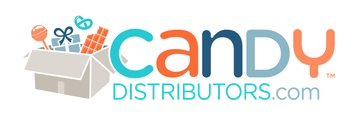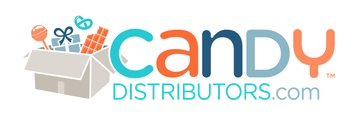

## Problem Statement:

In the fast-paced retail sector, precise sales forecasting is essential for efficient operations, stock management, and maintaining profitability. This project uses a four-year dataset from a US Based Candy Distribuitor to analyse trends and patterns.  By examining customer locations, factory deliveries, sales orders and product information, through exploratory data analysis (EDA), time series forecasting and regression techniques, the goal is to develop reliable predictions that help optimise business performance. The insights gained will support smarter decision-making, ensuring the distributor stays competitive and profitable.


## Data Description

- US Candy Distributor: 
The dataset includes Sales and geospatial factory to customer shipment data for a US national candy distributor, inlcuding information around customer & factory locations, sales orders & goals and product details.

https://mavenanalytics.io/data-playground?page=2&pageSize=5

- Candy_Sales.csv


#### Data Dictionary 

Most of the fields are self-explanatory.

- Row ID = Unique row identifier
- Order ID = Unique order identifier
- Order Date = Date of order
- Ship Mode = Shipping method of order
- Customer ID = Unique customer identifier
- Country/Region = Country or region of customer
- City = City of customer
- State/Province = State/province of customer
- Postal Code = Postal code / zip code of customer
- Division = Product division
- Region = Region of customer
- Product ID = Unique product identifier
- Product Name = Product long name
- Sales = otal sales value of order
- Units = Total units of order
- Gross = Profit Gross profit of order ( Sales - Cost )
- Cost = Cost to manufacture
- Factory = Factory Name



## Business questions

##### EDA Visualisation will be used to asnwer the business question:
- How do sales and profit compare across different countries, and what patterns emerge in their relationship?
- How do sales volume and profitability margins vary across states, and are there significant regional differences?
- How do sales growth trends vary across different states over time?
- Which months experience the lowest sales performance?
- Which are the 5 lowest-selling products?
- Which product lines demonstrate the highest profit margins, and what are the top 5 most profitable products?
- How does the cumulative sales count vary across different product categories over time?
- How does sales distribution vary across different product categories in our dataset?
- How does profit margin vary across different product categories in candy product line?
- How is sales distribution structured across product categories?
- How do cumulative sales and profit margins vary across product categories over time?
- Who are the top 10 customers by order volume, and what patterns define their purchasing behaviour?
- Which shipping method is most popular among customers?
- Which factory generates the highest total sales, and are there statistically significant differences in performance across factories?
- How does profit margin distribution vary across factories, and which demonstrate the most consistent profitability?
- How do factory performance metrics vary across different countries ?
- Do certain factory-country combinations demonstrate significantly faster or more consistent shipping times compared to others?
- How does shipping efficiency vary across factories and countries?
  

##  Hypotheses 

##### Two hypothesis tests will be conducted to answear business qiestion and gain deeper insight into the business:

-	Hypothesis 1: Does Shipping Mode Affect Profitability?

This could provide insights about whether the company should invest in faster delivery systems or whether certain delivery time thresholds significantly impact profitability. The results could inform logistics strategy and pricing models.

Null Hypothesis (H0): Profit percentage is independent of shipping mode (no significant difference in mean profit across shipping methods).
Alternative Hypothesis (H1): Profit percentage differs significantly by shipping mode, with slower methods associated with lower profitability.


-	Hypothesis 2 :  Candy Distributor want to know whether cost-tiered pricing or operational adjustments are needed: 
Do products with higher unit costs exhibit significantly different profit percentages compared to cheaper products?

H0 (Null): No significant difference exists in profit percentages between low and high cost products
H1 (Alternative): A statistically significant difference exists between low and high cost products 



## Import Libraries

In [1]:
#!pip install missingno

# Standard Library
import os
import time
import warnings
warnings.filterwarnings("ignore")

# Core Data Handling & Computation
import numpy as np
import pandas as pd
from scipy import stats

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from matplotlib.ticker import FuncFormatter

# Preprocessing & Feature Engineering
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import (
    train_test_split, GridSearchCV, 
    cross_val_score, TimeSeriesSplit, KFold
)
from sklearn.pipeline import Pipeline

# Machine Learning Models
## Regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

# Model Evaluation
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_percentage_error,
    mean_absolute_error, accuracy_score)
from math import sqrt

# Utilities
os.makedirs("saved_plots", exist_ok=True)  # Ensure output directory exists



## Reading the Datasets:

In [2]:
pd.set_option('display.max_columns', None) 

In [3]:
candy = pd.read_csv("Candy.csv")
candy.head(5)

,Row ID,Order ID,Order Date,Ship Mode,Customer ID,Country/Region,City,State/Province,Postal Code,Division,Region,Product ID,Product Name,Sales,Units,Gross Profit,Cost,Factory,Days to Ship
0,937,CA-2021-115777-CHO-NUT-13000,19 08 2021,Standard Class,115777,Canada,Montreal,Quebec,H1B,Chocolate,Atlantic,CHO-NUT-13000,Wonka Bar - Nutty Crunch Surprise,120.00,6,60.00,60.00,Lots ONuts,3
1,4750,CA-2023-169856-CHO-NUT-13000,7 05 2023,Standard Class,169856,Canada,Toronto,Ontario,M3C,NaN,Atlantic,CHO-NUT-13000,Wonka Bar - Nutty Crunch Surprise,120.00,6,60.00,60.00,Lots ONuts,3
2,8386,CA-2024-115777-CHO-NUT-13000,19 08 2024,Standard Class,115777,Canada,Montreal,Quebec,H1B,Chocolate,Atlantic,CHO-NUT-13000,Wonka Bar - Nutty Crunch Surprise,120.00,6,60.00,60.00,Lots ONuts,3
3,65,CA-2021-115238-CHO-FUD-51000,21 01 2021,Standard Class,115238,Canada,Toronto,Ontario,M7A,Chocolate,Atlantic,CHO-FUD-51000,Wonka Bar - Fudge Mallows,120.00,6,60.00,60.00,Lots ONuts,3
4,12,US-2021-130813-CHO-MIL-31000,6 01 2021,Second Class,130813,United States,Los Angeles,California,90049,Chocolate,Pacific,CHO-MIL-31000,Wonka Bar - Milk Chocolate,9.75,3,6.33,3.42,Wicked Choccys,2


## Data Preprocessing:

#### - Check the feature details 

In [4]:
candy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10194 entries, 0 to 10193
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          10194 non-null  int64  
 1   Order ID        10017 non-null  object 
 2   Order Date      10194 non-null  object 
 3   Ship Mode       10194 non-null  object 
 4   Customer ID     10194 non-null  int64  
 5   Country/Region  10085 non-null  object 
 6   City            10174 non-null  object 
 7   State/Province  10194 non-null  object 
 8   Postal Code     10194 non-null  object 
 9   Division        10148 non-null  object 
 10  Region          10194 non-null  object 
 11  Product ID      10194 non-null  object 
 12  Product Name    10170 non-null  object 
 13  Sales           10179 non-null  float64
 14  Units           10194 non-null  int64  
 15  Gross Profit    10194 non-null  float64
 16  Cost            10194 non-null  float64
 17  Factory         10194 non-null 

##### Dataset Overview:

The dataset contains 10,194 entries with 19 columns, covering order details, customer information and product data. Key fields include Order ID, Order Date, Ship Mode, Customer ID and location data (Country/Region, City, State/Province), alongside product-specific columns such as Product ID, Sales, Units, Gross Profit, and Cost. Most columns are complete, though a few (Order ID, Country/Region, Product Name) have minor missing values. Data types include floats, integers and strings.

#### - Check shape of data:

In [5]:
candy.shape

(10194, 19)

#### - Missing values: 

In [6]:
#Checking Null Values

candy.isnull().sum()

Row ID              0
Order ID          177
Order Date          0
Ship Mode           0
Customer ID         0
Country/Region    109
City               20
State/Province      0
Postal Code         0
Division           46
Region              0
Product ID          0
Product Name       24
Sales              15
Units               0
Gross Profit        0
Cost                0
Factory             0
Days to Ship        0
dtype: int64

#### - Visualising missing Values:

<Figure size 800x400 with 0 Axes>

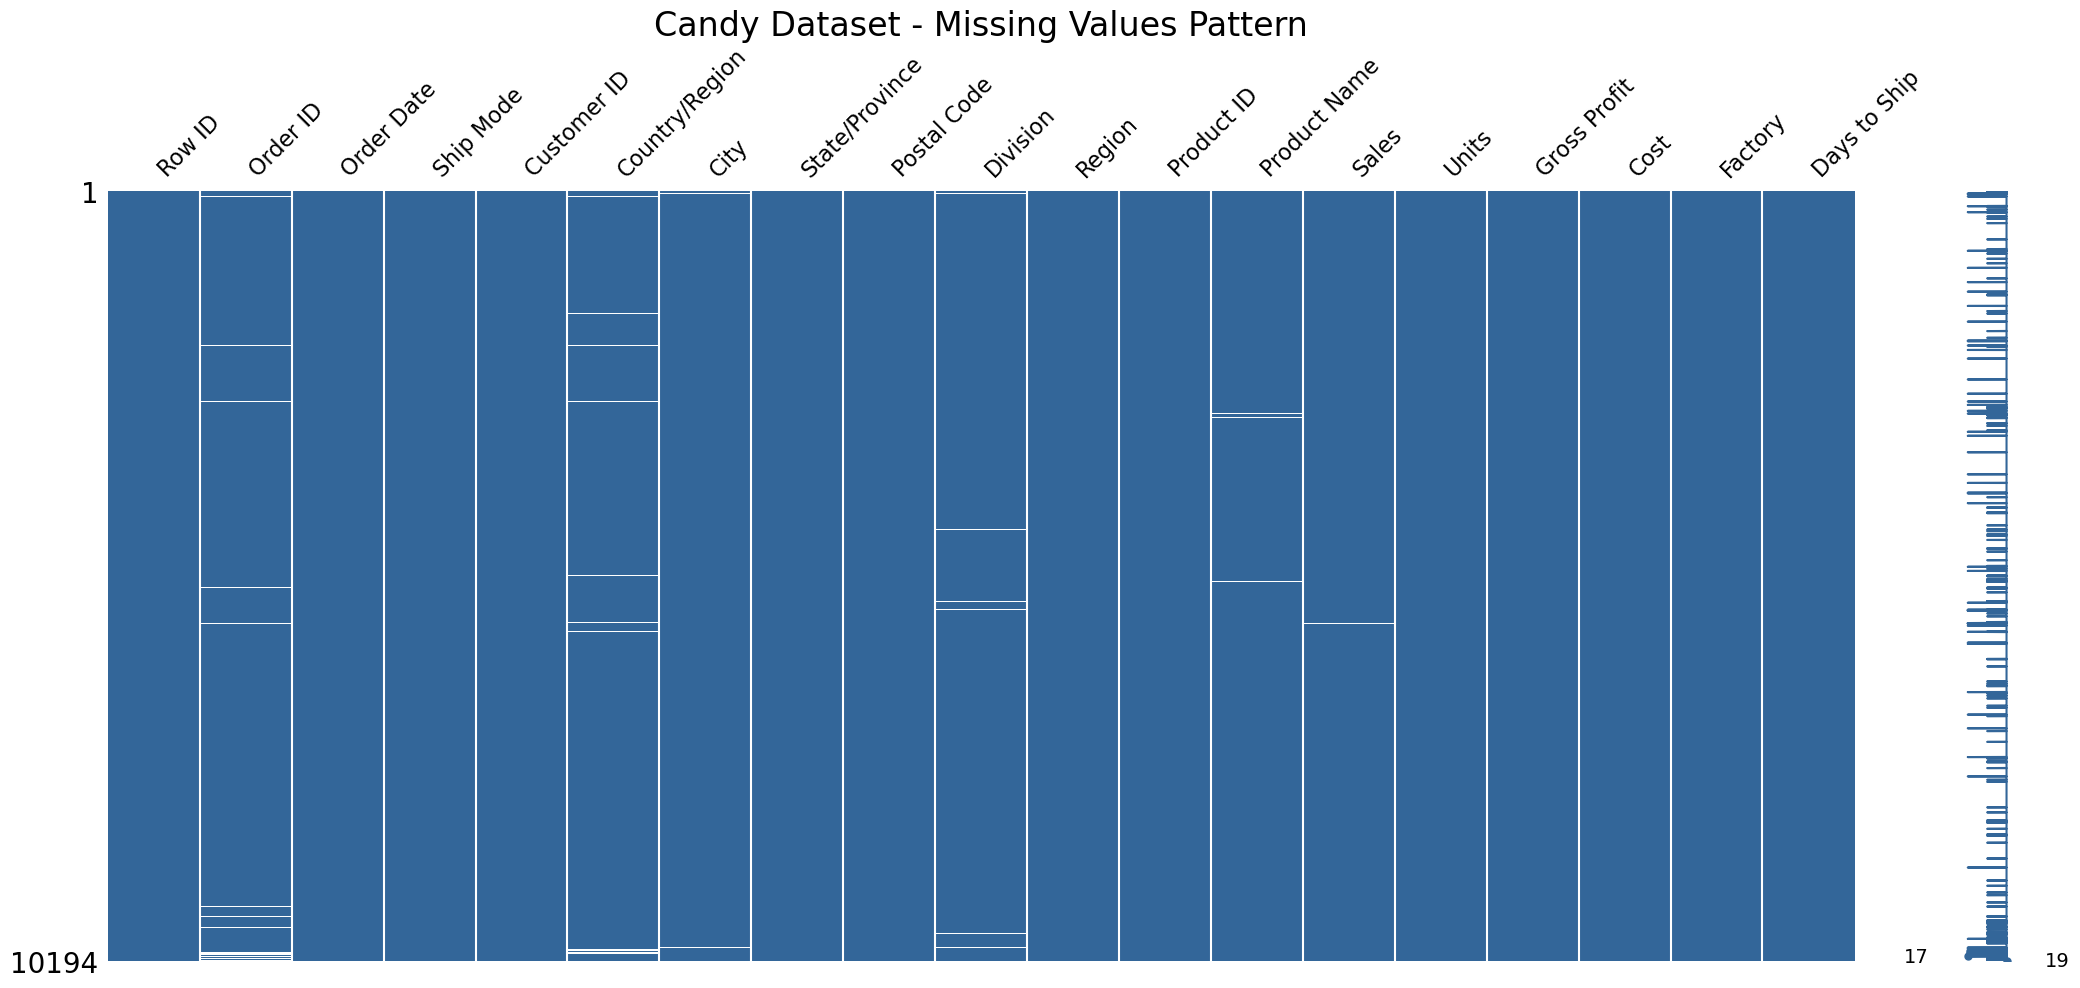

In [7]:
plt.figure(figsize=(8, 4))
msno.matrix(candy, color=(0.2, 0.4, 0.6)) 
plt.title('Candy Dataset - Missing Values Pattern', size=24)

plt.show()

#### - Handlying Missing Values

Since Customer ID , Region and Sales have very few missing values (<5% of the dataset), dropping rows is a safe and efficient strategy to maintain data integrity without significant loss.

In [8]:
candy= candy.dropna(subset=['Order ID', 'Country/Region', 'City', 'Division', 'Product Name', 'Sales'])

In [9]:
candy.isnull().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Mode         0
Customer ID       0
Country/Region    0
City              0
State/Province    0
Postal Code       0
Division          0
Region            0
Product ID        0
Product Name      0
Sales             0
Units             0
Gross Profit      0
Cost              0
Factory           0
Days to Ship      0
dtype: int64

- The dataset has now been cleaned, with no remaining missing values.

#### Number of unique values in each column:

In [10]:
candy.nunique()

Row ID            9886
Order ID          8318
Order Date        1235
Ship Mode            4
Customer ID       4966
Country/Region       2
City               541
State/Province      59
Postal Code        653
Division             3
Region               4
Product ID          15
Product Name        15
Sales               82
Units               14
Gross Profit       111
Cost                85
Factory              5
Days to Ship         6
dtype: int64

#### - Drop Unwanted Features:

Since they do not contribute to the analysis and some introduce redundancy.

In [11]:
candy.drop(columns=['Row ID', 'Postal Code', 'City', 'Product ID'], inplace=True)

#### - Rename Columns and atibuites for readibility: 

In [12]:
candy = candy.rename(columns={
    'Division': 'Category',
    'Product Name': 'Product',
    'Order Date': 'Order_Date',
    'Ship Date': 'Ship_Date',
    'Gross Profit': 'Profit',
    'Customer ID': 'CustomerID',
     'Product ID': 'ProductID',
    'Order ID': 'OrderID',
    'Country/Region': 'Country',
    'State/Province': 'State',
    'Units': 'Qty',
    'Ship Mode': 'Ship_Mode',
    'Days to Ship': 'Ship_Time'
})


In [13]:
candy['Product'] = candy['Product'].str.replace('-', ' ')

In [14]:
## rremove all hyphens (-) from the Product column and replace them with spaces

candy['Product'] = candy['Product'].str.replace('-', ' ')

#### Checking for duplicated values:

In [15]:
dup = candy.duplicated().sum()
print(f"Number of duplicated rows: {dup}")


Number of duplicated rows: 301


In [16]:
duplicated = candy[candy.duplicated(keep='first')]
duplicated.head(5)

,OrderID,Order_Date,Ship_Mode,CustomerID,Country,State,Category,Region,Product,Sales,Qty,Profit,Cost,Factory,Ship_Time
19,CA-2021-153623-CHO-SCR-58000,24 11 2021,Standard Class,153623,Canada,Newfoundland and Labrador,Chocolate,Atlantic,Wonka Bar Scrumdiddlyumptious,100.00,5,50.00,50.0,Lots ONuts,3
23,US-2021-146591-CHO-TRI-54000,19 01 2021,First Class,146591,United States,Arizona,Chocolate,Pacific,Wonka Bar Triple Dazzle Caramel,18.75,5,12.25,6.5,Wicked Choccys,2
175,US-2021-114790-CHO-TRI-54000,11 03 2021,Second Class,114790,United States,Kentucky,Chocolate,Gulf,Wonka Bar Triple Dazzle Caramel,11.25,3,7.35,3.9,Wicked Choccys,2
202,US-2024-100223-CHO-SCR-58000,5 07 2024,Standard Class,100223,United States,Texas,Chocolate,Interior,Wonka Bar Scrumdiddlyumptious,32.40,9,22.50,9.9,Lots ONuts,4
219,US-2021-133424-CHO-SCR-58000,30 03 2021,Standard Class,133424,United States,Washington,Chocolate,Pacific,Wonka Bar Scrumdiddlyumptious,10.80,3,7.50,3.3,Lots ONuts,4


In [17]:
candy_df_drop = candy.drop_duplicates()
remaining_duplicates = candy.duplicated().sum()
print(f"Duplicates remaining after drop: {remaining_duplicates}")


Duplicates remaining after drop: 301


#### - Convert Data Type

In [18]:
candy['CustomerID'] = candy['CustomerID'].astype('Int64').astype(str)

In [19]:
candy['Order_Date'] = pd.to_datetime(candy['Order_Date'], dayfirst=True, errors='coerce')


In [20]:
print(f" start_date is from {candy['Order_Date'].min()} - end_date is to {candy['Order_Date'].max()}")

 start_date is from 2021-01-03 00:00:00 - end_date is to 2024-12-30 00:00:00


#### - Feature engineering 

- Since the machine learning models were underperforming, new features were developed to improve the results.

In [21]:
# Extract temporal features

candy['Order_Date'] = pd.to_datetime(candy['Order_Date'], dayfirst=True, errors='coerce')
candy['Order_Day'] = candy['Order_Date'].dt.day
candy['Order_Month'] = candy['Order_Date'].dt.month
candy['Order_Year'] = candy['Order_Date'].dt.year
candy['Order_DayOfWeek'] = candy['Order_Date'].dt.dayofweek
candy['Order_Quarter'] = candy['Order_Date'].dt.quarter

In [22]:
# Customer Order Frequency: Number of orders per customer.

candy['Customer_Order_Count'] = candy.groupby('CustomerID')['OrderID'].transform('count')

In [23]:
# Average Sales per Customer:

candy['Sales_Per_Customer'] = candy.groupby('CustomerID')['Sales'].transform('mean')

In [24]:
# Customer loyalty

candy['Customer_Tenure'] = candy.groupby('CustomerID')['Order_Date'].transform(lambda x: (x.max() - x.min()).days)



In [25]:
# Bulk order indicators

candy['Is_Bulk_Order'] = (candy['Qty'] > candy['Qty'].quantile(0.9)).astype(int)


In [26]:
# Product lifecycle (time since first order)

candy['Product_Age'] = candy.groupby('Product')['Order_Date'].rank(method='dense')


In [27]:
# Promotional periods 

candy['Is_Holiday'] = candy['Order_Month'].isin([10, 12]).astype(int)


In [28]:
candy['Order_Month_sin'] = np.sin(2 * np.pi * candy['Order_Month'] / 12)
candy['Order_DayOfWeek_cos'] = np.cos(2 * np.pi * candy['Order_DayOfWeek'] / 7)


In [29]:
# Price elasticity proxies

candy['Price_Per_Unit'] = candy['Sales'] / candy['Qty']
candy['Cost_Per_Unit'] = candy['Cost'] / candy['Qty']


## Descriptive analysis

In [30]:
candy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9886 entries, 0 to 10189
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   OrderID               9886 non-null   object        
 1   Order_Date            9886 non-null   datetime64[ns]
 2   Ship_Mode             9886 non-null   object        
 3   CustomerID            9886 non-null   object        
 4   Country               9886 non-null   object        
 5   State                 9886 non-null   object        
 6   Category              9886 non-null   object        
 7   Region                9886 non-null   object        
 8   Product               9886 non-null   object        
 9   Sales                 9886 non-null   float64       
 10  Qty                   9886 non-null   int64         
 11  Profit                9886 non-null   float64       
 12  Cost                  9886 non-null   float64       
 13  Factory               

##### Numerical Features:

In [31]:
candy[['Sales', 'Cost', 'Profit', 'Qty']].describe()

,Sales,Cost,Profit,Qty
count,9886.000000,9886.000000,9886.000000,9886.000000
mean,14.438227,4.948748,9.461881,3.872446
std,11.137400,4.989538,6.453915,2.187335
min,2.500000,1.000000,0.500000,1.000000
25%,7.200000,2.400000,4.980000,2.000000
50%,10.800000,3.900000,7.470000,3.000000
75%,18.000000,6.000000,12.250000,5.000000
max,260.000000,130.000000,130.000000,14.000000


- Sales: The average sale amount is 14.44, with a relatively high standard deviation 11.14, indicating significant variability. Sales range from 2.50 to 260, with the median (50th percentile) at 10.80, with some right-skewness due to higher maximum values.

- Cost: The mean cost is 4.95, with a standard deviation of 4.99, showing considerable spread. Costs vary from 1 to 130, while the median is 3.90, again indicating potential skewness from extreme high-cost items.

- Profit: The average profit is 9.46, with a standard deviation of 6.45. Profits range from 0.50 to 130, with the median at 7.47, reinforcing the presence of outliers or high-value transactions.

- Quantity Sold (Qty): The average quantity per transaction is 3.87 units, with a standard deviation of 2.19. The median is 3, and values range from 1 to 14 units,  whre most sales involve smaller quantities, with occasional bulk purchases

The wide ranges and high standard deviations suggest significant variability in sales, costs, and profits, possibly due to a mix of low- and high-value transactions. The medians are lower than the means for sales, cost, and profit, indicating right-skewed distributions where a few high-value transactions pull the average up. Profitability appears consistent relative to sales.

In [32]:
numerical = ['Sales', 'Cost', 'Profit', 'Qty']

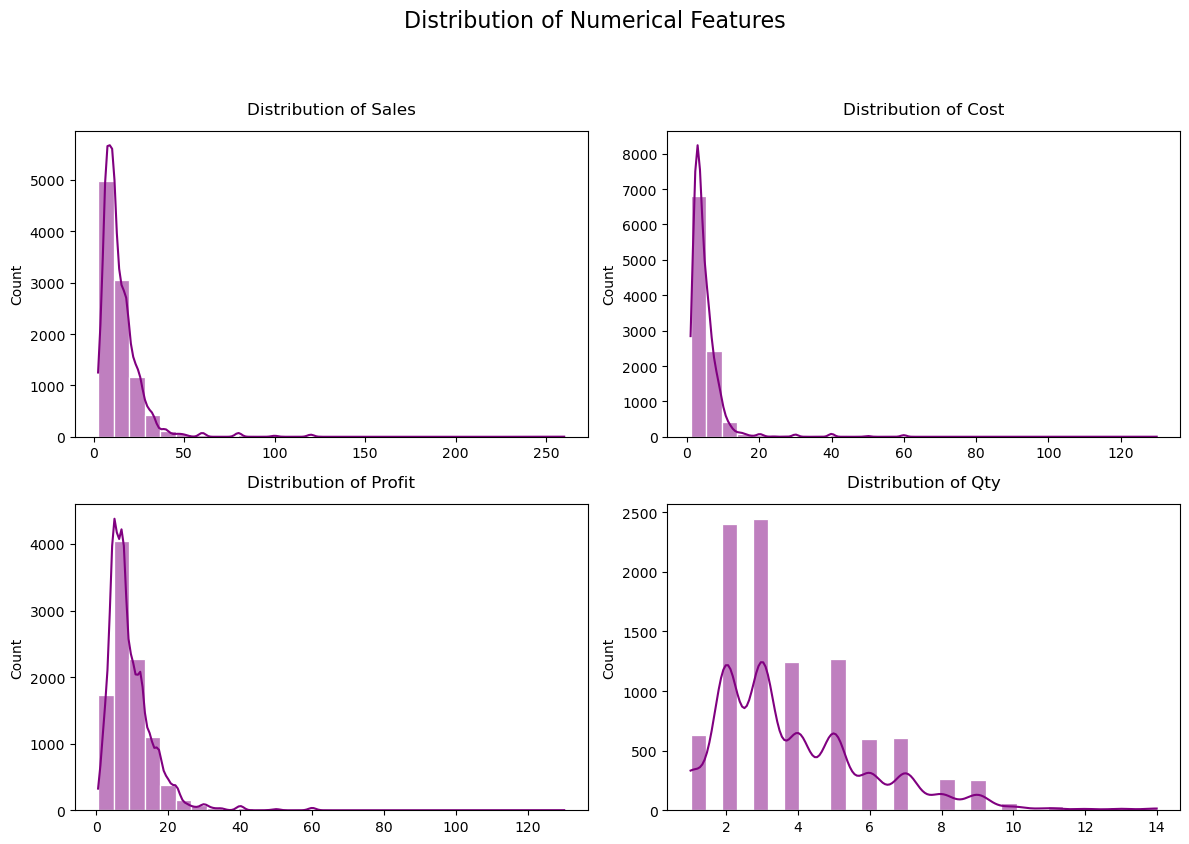

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8)) 
fig.suptitle('Distribution of Numerical Features', fontsize=16, y=1.05)  

for ax, col in zip(axes.flatten(), numerical):
    sns.histplot(candy[col], 
                 kde=True, 
                 bins=30, 
                 ax=ax, 
                 color='purple',
                 edgecolor='white')  
    ax.set_title(f'Distribution of {col}', pad=12)
    ax.set_xlabel('')  
    
plt.tight_layout()

plt.show()

##### Categorical Features 

In [34]:
candy.describe(include= object)

,OrderID,Ship_Mode,CustomerID,Country,State,Category,Region,Product,Factory
count,9886,9886,9886,9886,9886,9886,9886,9886,9886
unique,8318,4,4966,2,59,3,4,15,5
top,US-2021-155502-CHO-MIL-31000,Standard Class,115238,United States,California,Chocolate,Pacific,Wonka Bar Scrumdiddlyumptious,Lots ONuts
freq,5,5943,19,9695,1945,9614,3153,2049,5648


- OrderID: There are 8,318 unique order IDs, with the most frequent appearing 5 times.
- Ship_Mode: The most common shipping method is "Standard Class", used in 5,943 orders.
- CustomerID: There are 4,966 unique customers, with the most frequent customer (ID: 115238) placing 19 orders.
- Country: The majority of orders (9,695) come from the United States, with only a small portion from another country (likely international orders).
- State: California has the highest number of orders (1,945), followed by other states.
- Category: Chocolate is the most popular category, appearing in 9,614 orders.
- Region: The Pacific region has the most orders (3,153).
- Product: The "Wonka Bar Scrumdiddlyumptious" is the top-selling product, ordered 2,049 times.
- Factory: The factory "Lots ONuts" produces the majority of products (5,648 orders).

The Candy Distribuitor primarily serves US customers, with chocolate products being the most popular, particularly those manufactured by "Lots ONuts". The Pacific region and California are key markets and standard shipping is the preferred delivery method.

### - Check the Normality of the dataset 

Using Histogram with KDE and Q-Q Plot, along with Log Transformation to address/handle skewness:

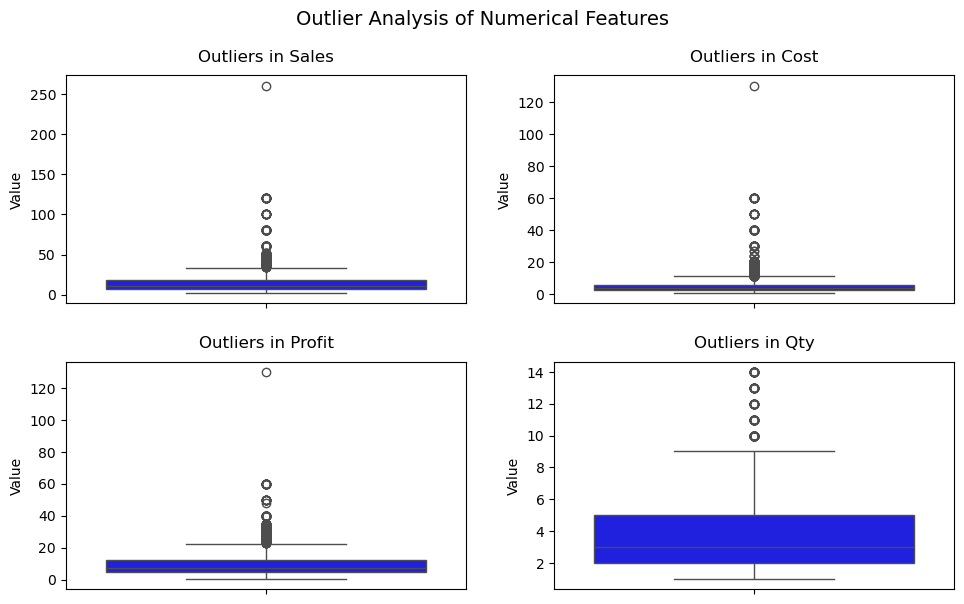

In [35]:
numerical = ['Sales', 'Cost', 'Profit', 'Qty']


plt.figure(figsize=(10, 6)) 

for i, col in enumerate(numerical, 1):
    plt.subplot(2, 2, i)  
    sns.boxplot(y=candy[col], color='blue')
    plt.title(f'Outliers in {col}', pad=10)
    plt.ylabel('Value')
    
plt.tight_layout(pad=2) 
plt.suptitle('Outlier Analysis of Numerical Features', y=1.02, fontsize=14)
plt.savefig("saved_plots/sales_trend.png")
plt.show()

The medians are lower than the means, indicating right-skewed distributions where a few high-value transactions pull the average up. 

#### -Log Transformation to treat data Skew:

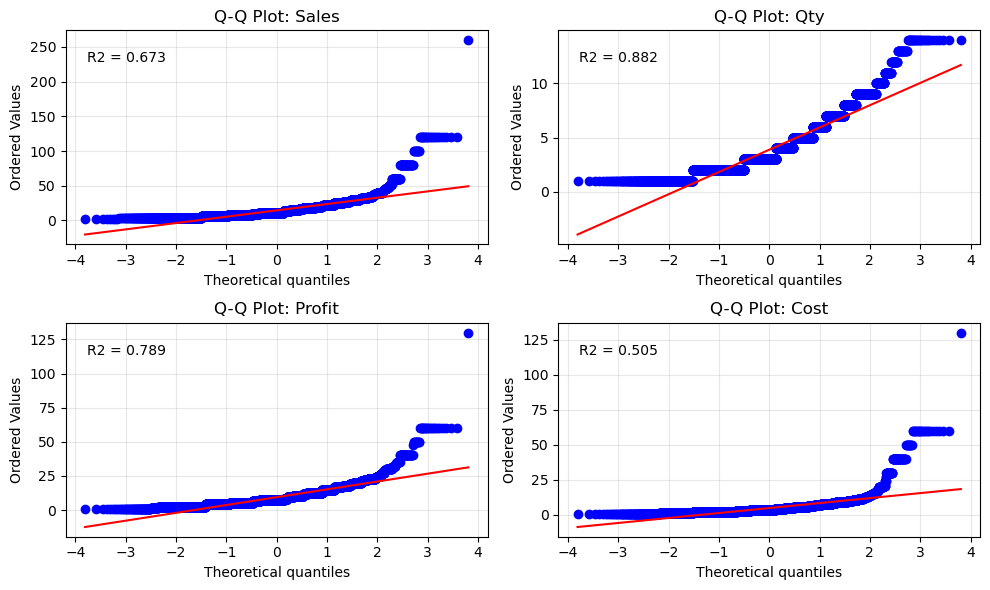

In [36]:
numeric_cols = ['Sales', 'Qty', 'Profit', 'Cost']


plt.figure(figsize=(10, 6))


for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    stats.probplot(candy[col], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot: {col}', fontsize=12)
    plt.grid(True, alpha=0.3)

    (osm, osr), (slope, intercept, r) = stats.probplot(candy[col], dist="norm")
    plt.annotate(f'R2 = {r**2:.3f}', xy=(0.05, 0.85), xycoords='axes fraction')

plt.tight_layout()
plt.savefig("saved_plots/sales_trend.png")
plt.show()

##### Features log transformation:

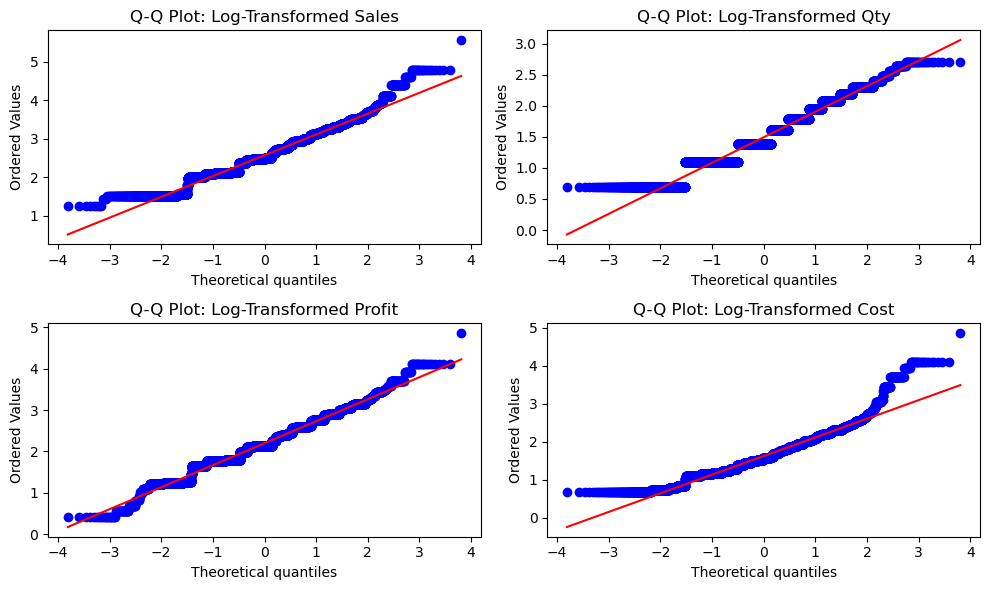

In [37]:
# log1p transformation to target columns:

candy[numeric_cols] = np.log1p(candy[numeric_cols])
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    stats.probplot(candy[col], dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot: Log-Transformed {col}')

plt.tight_layout()
plt.savefig("saved_plots/sales_trend.png")
plt.show()

- After applying the log transformation, the features now follow a distribution that is much closer to normal, as seen by their alignment with the red reference line.

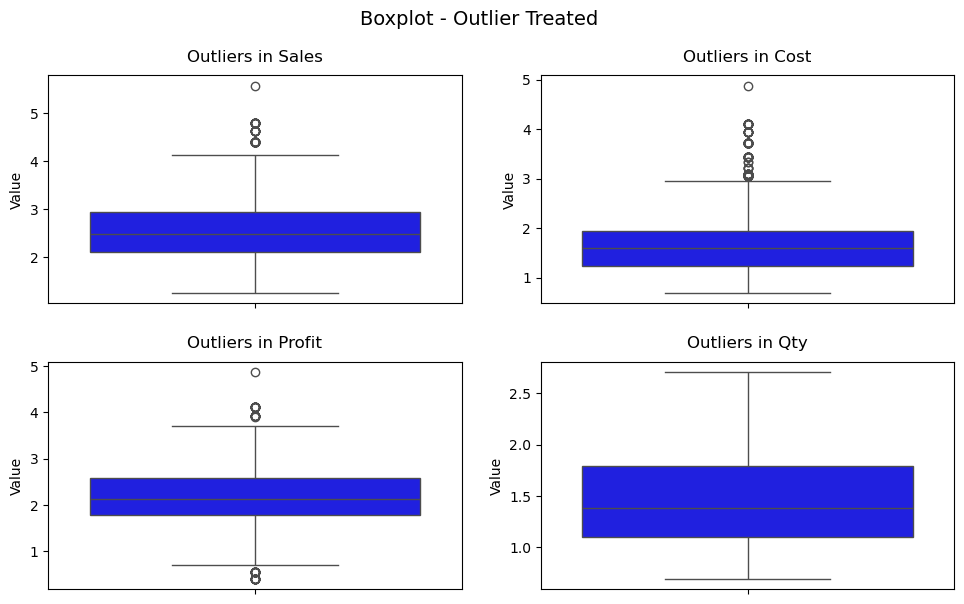

In [38]:
plt.figure(figsize=(10, 6)) 


for i, col in enumerate(numerical, 1):
    plt.subplot(2, 2, i)  
    sns.boxplot(y=candy[col], color='blue')
    plt.title(f'Outliers in {col}', pad=10)
    plt.ylabel('Value')
    
plt.tight_layout(pad=2)  
plt.suptitle('Boxplot - Outlier Treated ', y=1.02, fontsize=14)
plt.savefig("saved_plots/sales_trend.png")
plt.show()

- The dataset had a long tail, with a few extremely high sales values skewing the distribution. Applying a log transform made the data more symmetrical by reducing the impact of these extremes. Previously, the boxplot showed many outliers due to this skew, but after transformation, the values are better balanced. This improvement aligns with regression models’ preference for normally distributed data. :)

# Exploratory Data Analysis EDA:

In [39]:
candy_df = candy.copy(deep=True)

### 1. Sales & Profit Analysis


#### 1.1 Annual Sales: 

In [40]:
candy_df['Order_Year'] = candy_df['Order_Date'].dt.year
annual_sales = candy_df.groupby('Order_Year')['Sales'].sum().reset_index()

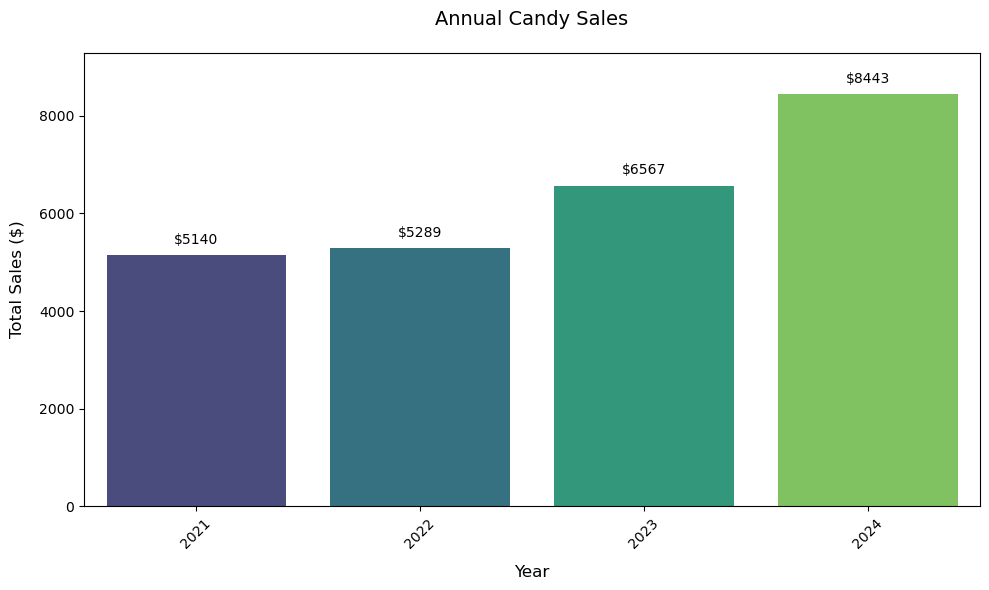

In [41]:
plt.figure(figsize=(10, 6))

ax = sns.barplot(x='Order_Year', y='Sales', data=annual_sales, palette='viridis')
ax.grid(False) 

plt.title('Annual Candy Sales', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12, labelpad=10)
plt.ylabel('Total Sales ($)', fontsize=12, labelpad=10)
plt.xticks(rotation=45)


max_sales = annual_sales['Sales'].max()
label_offset = 0.02 * max_sales  


for index, row in annual_sales.iterrows():
    y_pos = min(row['Sales'] + label_offset, max_sales * 1.05)  
    ax.text(index, 
            y_pos, 
            f'${row["Sales"]:.0f}', 
            ha='center', 
            va='bottom',
            fontsize=10)

plt.ylim(0, max_sales * 1.1)
plt.tight_layout()
plt.savefig("saved_plots/sales_trend.png")
plt.show()

The barchart shows a consistent year-on-year increase in sales, rising from 5,140.00 in 2021 to 8,443.00 in 2024, indicating strong growth over the four-year period. The most significant jump occurred between 2023 (6,567.00) and 2024 (8,443.00), sshowing an accelerated performance in the most recent year.

#### - 1.2 Sales per Country: 

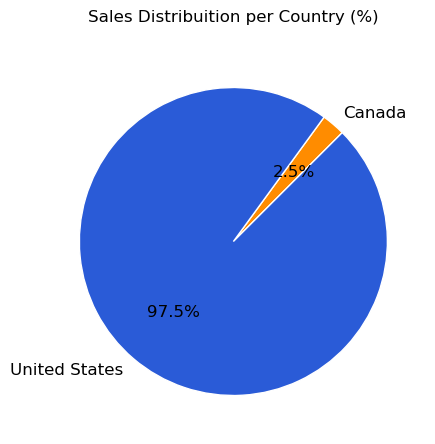

In [42]:
country_sales = candy_df.groupby('Country')['Sales'].sum()

plt.figure(figsize=(5, 5))
country_sales.plot.pie(
    colors=['#ff8c00' , '#2a5bd7'],
    autopct='%.1f%%',
    fontsize=12,
    wedgeprops={'edgecolor': 'white'},
    startangle=45,
)
plt.ylabel('') 
plt.title('Sales Distribuition per Country (%)', pad=20)
plt.savefig("saved_plots/sales_trend.png")
plt.show()

- The majority of orders 97.5% come from the United States, with only a small portion 2.5% from Canada. 

#### 1.3 Cross-Country Comparison: How do sales and profit compare across different countries, and what patterns emerge in their relationship?

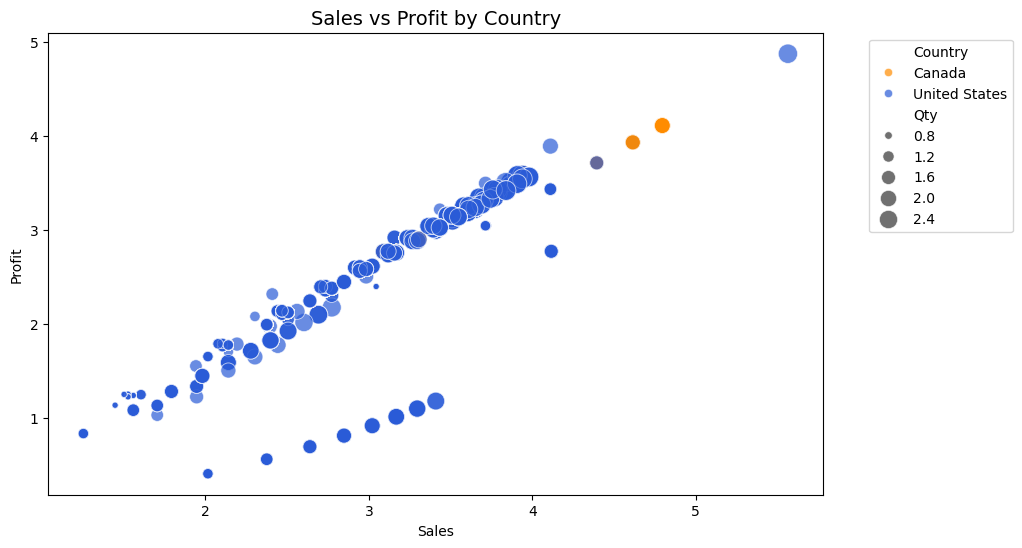

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Sales', y='Profit', data=candy_df,
                hue='Country', palette=['#ff8c00', '#2a5bd7'],
                alpha=0.7, size='Qty', sizes=(20, 200))
plt.title('Sales vs Profit by Country', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("saved_plots/sales_trend.png")
plt.show()

- The chart shows significantly stronger sales and profitability in the US market compared to Canada. While the US demonstrates consistent high-volume transactions driving substantial profits, Canada's market activity appears limited to fewer but larger bulk purchases. Some somes has very low profit. 

#### 1.4 Regional Trends: How do sales volume and profitability margins vary across states, and are there significant regional differences?



In [44]:
# Calculate stats and sort by sales
state_stats = candy_df.groupby('State').agg({'Sales':'sum', 'Profit':'sum'})
state_stats['Profit Margin'] = state_stats['Profit'] / state_stats['Sales']

# Display top 5 states formatted nicely
top_states = state_stats.nlargest(5, 'Sales').style.format({
    'Sales': '${:,.2f}',
    'Profit': '${:,.2f}', 
    'Profit Margin': '{:.2%}'
})

top_states

,Sales,Profit,Profit Margin
State,,,
California,"$4,996.82","$4,276.15",85.58%
New York,"$2,771.00","$2,364.66",85.34%
Texas,"$2,449.52","$2,096.15",85.57%
Pennsylvania,"$1,450.26","$1,233.14",85.03%
Washington,"$1,251.28","$1,071.94",85.67%


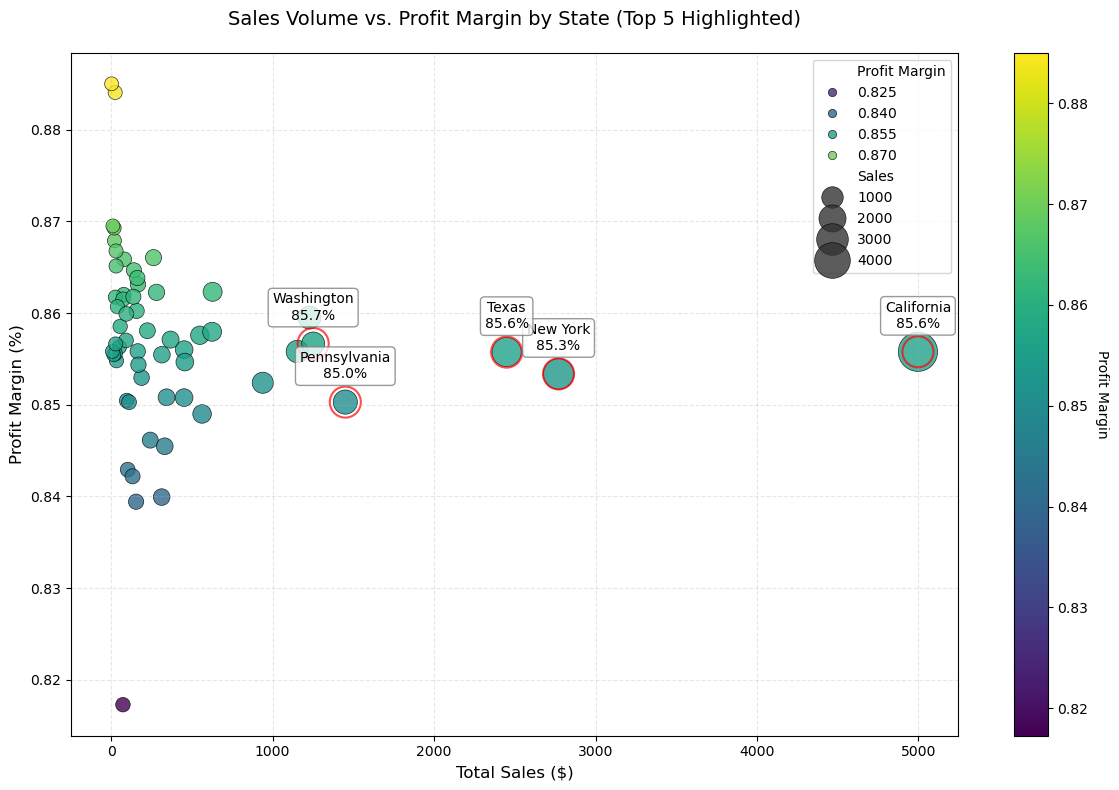

In [45]:
plt.figure(figsize=(12, 8))
ax = plt.gca() 
scatter = sns.scatterplot(
    data=state_stats, 
    x='Sales', 
    y='Profit Margin', 
    size='Sales',
    sizes=(100, 800),
    hue='Profit Margin', 
    palette='viridis',
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5,
    ax=ax 
)

plt.title('Sales Volume vs. Profit Margin by State (Top 5 Highlighted)', fontsize=14, pad=20)
plt.xlabel('Total Sales ($)', fontsize=12)
plt.ylabel('Profit Margin (%)', fontsize=12)
plt.grid(linestyle='--', alpha=0.3)

# top 5 states
top_5 = state_stats.nlargest(5, 'Sales')
for state in top_5.index:
    ax.scatter(
        x=top_5.loc[state, 'Sales'],
        y=top_5.loc[state, 'Profit Margin'],
        s=500,
        facecolors='none',
        edgecolors='red',
        linewidths=1.5,
        alpha=0.7
    )
    ax.annotate(
        f"{state}\n{top_5.loc[state,'Profit Margin']:.1%}",
        (top_5.loc[state, 'Sales'], top_5.loc[state, 'Profit Margin']),
        textcoords="offset points",
        xytext=(0,15),
        ha='center',
        va='bottom',
        fontsize=10,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.8)
    )

norm = plt.Normalize(state_stats['Profit Margin'].min(), state_stats['Profit Margin'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)  
cbar.set_label('Profit Margin', rotation=270, labelpad=15)

plt.tight_layout()
plt.savefig("saved_plots/sales_trend.png")
plt.show()




- California dominates in absolute sales (4,996.82) and profit (4,276.15), though Washington achieves the highest profit margin (85.67%) among the top five states, indicating superior cost efficiency despite its smaller sales volume (1,251.28). New York and Texas show nearly identical margins (85.5%) to California, suggesting consistent operational performance across these high-volume markets, while Pennsylvania's slightly lower margin (85.03%) may indicate opportunities for cost optimisation. Notably, all five states maintain strong margins above 85%, demonstrating generally effective pricing strategies and cost control across key markets, with Washington's outlier performance potentially offering best practices for others to emulate.

#### 1.5 Growth Over Time: How do sales growth trends vary across different states over time?


<Figure size 1200x500 with 0 Axes>

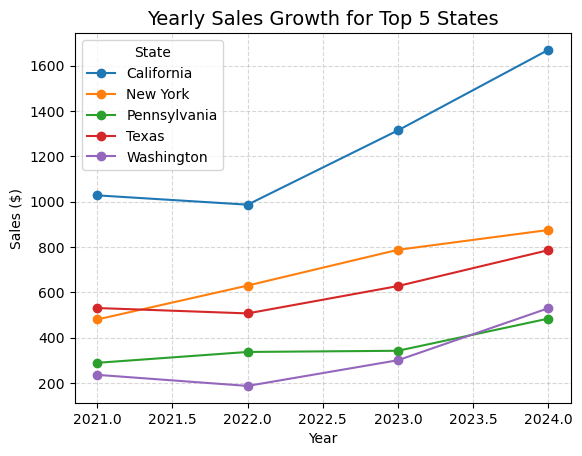

In [46]:
 #Growth Trends by State

state_sales = candy_df.groupby('State')['Sales'].sum().sort_values(ascending=False)
top_states = state_sales.head(5).index
yearly_sales = candy_df[candy_df['State'].isin(top_states)].groupby(['State', 'Order_Year'])['Sales'].sum().unstack()

plt.figure(figsize=(12, 5))
yearly_sales.T.plot(marker='o')
plt.title('Yearly Sales Growth for Top 5 States', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Sales ($)')
plt.grid(linestyle='--', alpha=0.5)
plt.legend(title='State')
plt.savefig("saved_plots/sales_trend.png")
plt.show();

- The year on year sales analysis reveals strong growth across all key states, with California maintaining market dominance (reaching 1,669k in 2024) and showing consistent annual expansion. New York demonstrates steady progress (from 480k to 875k), while Texas exhibits particularly robust recovery post-2022 (jumping from 507k to 785k). Washington stands out with remarkable acceleration in 2024 (a 77% surge from 2023 to 529k), suggesting successful market initiatives. Pennsylvania, though showing more modest growth, maintained stable increases each year. The data indicates all states benefited from improving market conditions, with California's exceptional performance potentially reflecting both market size and operational advantages.

#### 1.6 Seasonality: Which months experience the lowest sales performance?



In [47]:
candy_df['Month_Name'] = candy_df['Order_Date'].dt.month_name()

monthly_sales = candy_df.groupby(['Order_Month', 'Month_Name'])['Sales'].sum().reset_index()
monthly_sales = monthly_sales.sort_values('Order_Month')

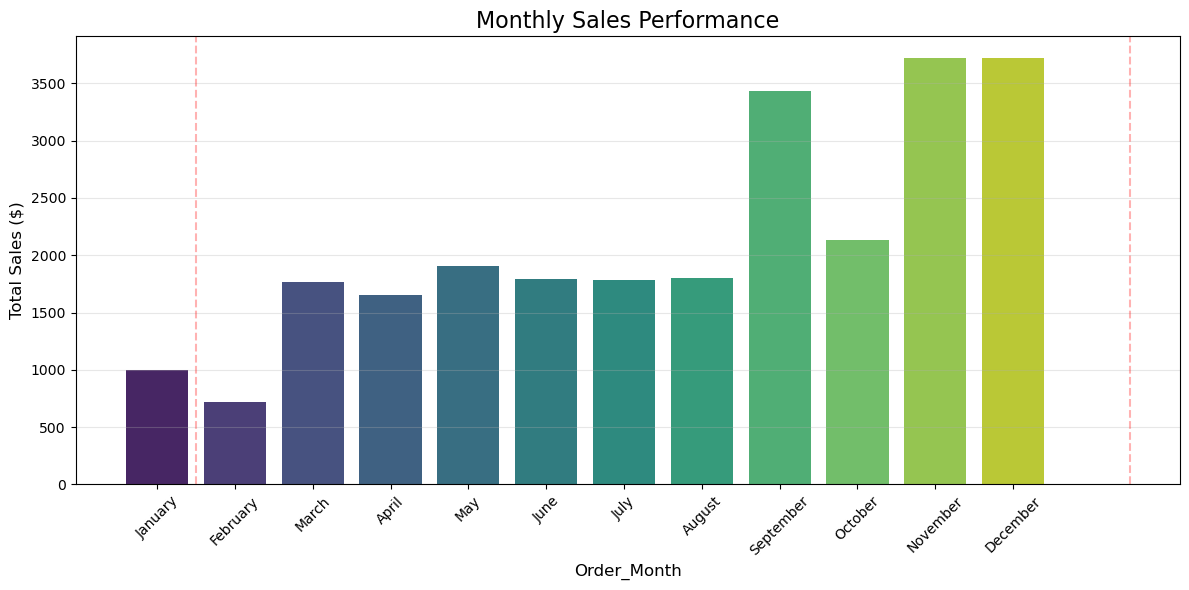

In [48]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Month_Name', y='Sales', data=monthly_sales, palette='viridis')


plt.title('Monthly Sales Performance', fontsize=16)
plt.xlabel('Order_Month', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

lowest_month = monthly_sales.loc[monthly_sales['Sales'].idxmin(), 'Month_Name']
plt.axvline(x=monthly_sales['Order_Month'].min()-0.5, color='red', linestyle='--', alpha=0.3)
plt.axvline(x=monthly_sales['Order_Month'].max()+0.5, color='red', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("saved_plots/sales_trend.png")
plt.show()

In [49]:
slowest_months = monthly_sales.nsmallest(3, 'Sales')[['Month_Name', 'Sales']]
print("Slowest Sales Months:")
print(slowest_months.to_string(index=False))

Slowest Sales Months:
Month_Name       Sales
  February  721.843253
   January 1002.513601
     April 1653.500572


- The monthly sales analysis reveals a clear seasonal pattern, with December and November  emerging as peak sales months, likely driven by holiday demand, followed by September which may reflect back to school purchasing. Summer months (May-August) show consistently strong performance , while February appears to be the weakest month, potentially due to post-holiday lulls. Notably, sales triple from the lowest (February) to highest (December) months, suggesting significant seasonality that could inform inventory planning and marketing strategies.

### 2. Product Performance


#### 2.1 Low Performers: Which are the 5 lowest-selling products?




In [50]:
low_sales = candy_df.groupby('Product')['Sales'].sum().sort_values().head(5)

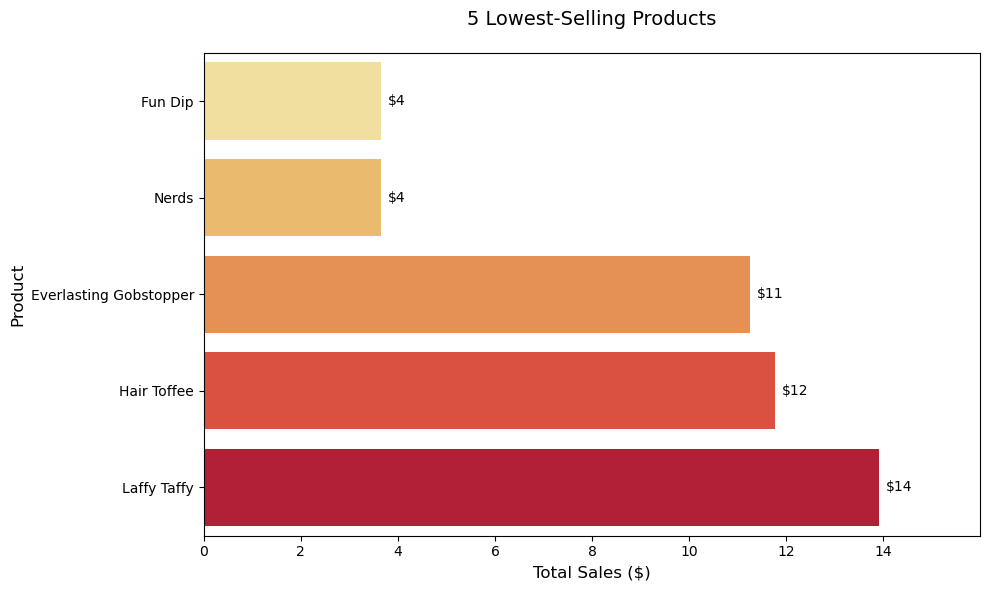

In [51]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=low_sales.values, y=low_sales.index, palette='YlOrRd', orient='h')

plt.title('5 Lowest-Selling Products', fontsize=14, pad=20)
plt.xlabel('Total Sales ($)', fontsize=12)
plt.ylabel('Product', fontsize=12)
plt.xlim(0, max(low_sales) * 1.15) 

for i, value in enumerate(low_sales):
    ax.text(value + (max(low_sales)*0.01),  
            i,                             
            f'${value:,.0f}',              
            va='center',                   
            ha='left',                     
            fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.grid(False)
plt.tight_layout()
plt.savefig("saved_plots/sales_trend.png")

plt.show()

- Fun Dip and Nerds are the lowest-performing products, with significantly lower sales (3.65 each) compared to better-selling items like Laffy Taffy (13.90) and Hair Toffee (11.77). This substantial gap show these two products may require targeted interventions—such as promotional campaigns, product improvements or strategic pricing adjustments to enhance their market appeal and commercial performance.

#### 2.2 High Margins: Which product lines demonstrate the highest profit margins, and what are the top 5 most profitable products?




In [52]:
 # Calculate product profitability
product_profitability = candy_df.groupby('Product').agg({
    'Profit': 'sum',
    'Sales': 'sum'
}).reset_index()

# Calculate profit margin (%)
product_profitability['Profit_Margin'] = (product_profitability['Profit'] / product_profitability['Sales']) * 100

# Get top 5 most profitable products
top_products = product_profitability.nlargest(5, 'Profit')

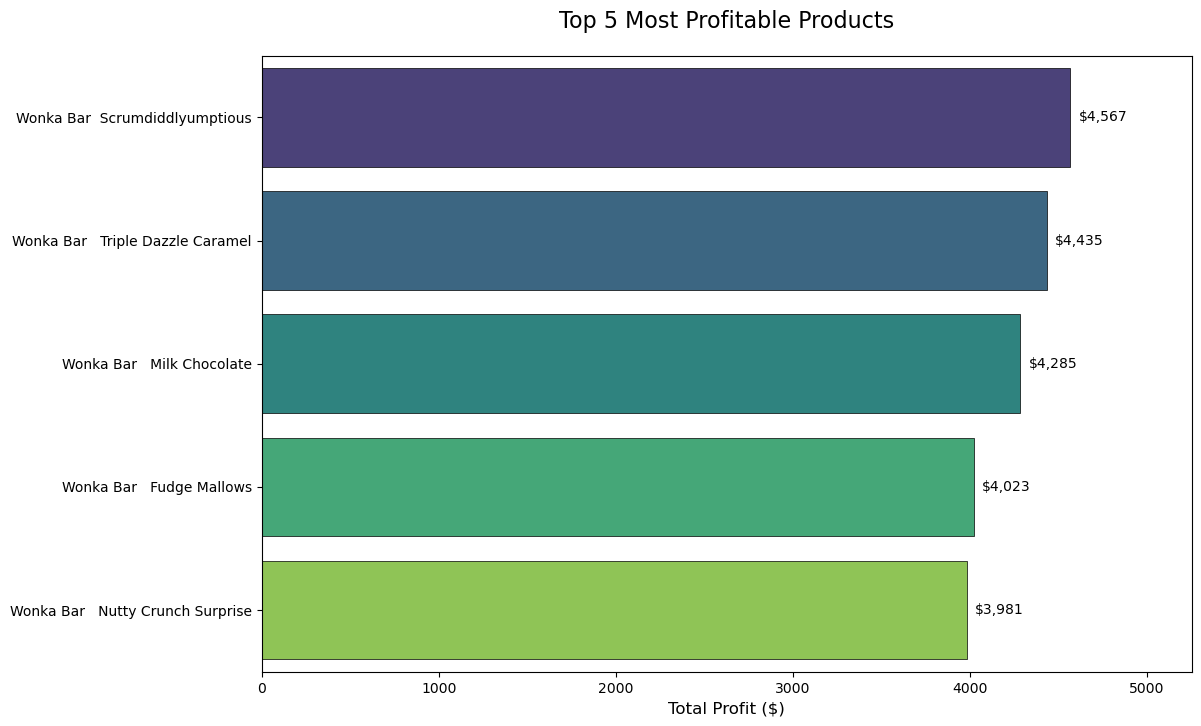

In [53]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=top_products,
    x='Profit',
    y='Product',
    palette='viridis',
    edgecolor='black',
    linewidth=0.5
)

for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + (0.01 * top_products['Profit'].max()),  
        p.get_y() + p.get_height() / 2, 
        f'${width:,.0f}',
        va='center',
        fontsize=10
    )

plt.title('Top 5 Most Profitable Products', fontsize=16, pad=20)
plt.xlabel('Total Profit ($)', fontsize=12)
plt.ylabel('')
plt.xlim(0, top_products['Profit'].max() * 1.15) 
plt.show()

#### Category Trends:

#### 2.3  How do cumulative sales and profit margins vary across product categories over time?
#### 2.4  How is sales distribution structured across product categories?


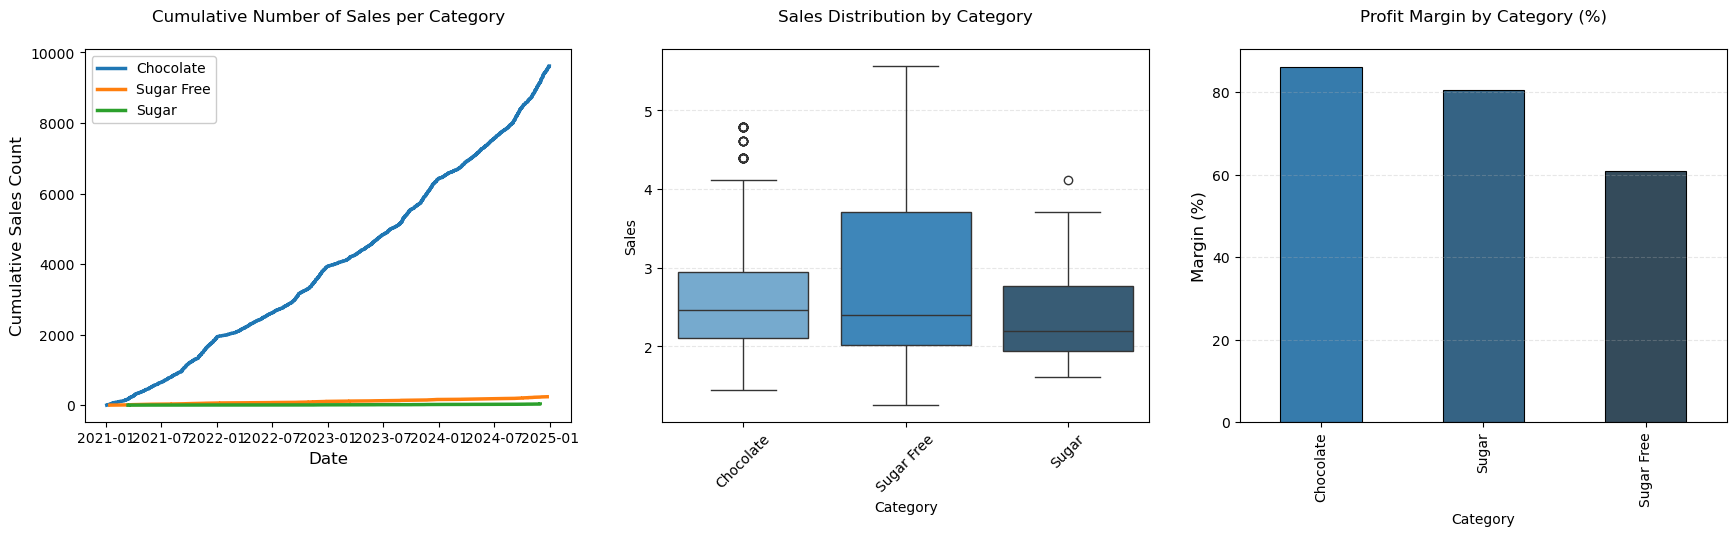

In [54]:
product_category = candy_df.groupby('Category')['Sales'].sum()
product_category


# 2.5 How does the cumulative sales count vary across different product categories over time?

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title('Cumulative Number of Sales per Category', pad=20)
categories = candy_df['Category'].unique()

line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 

for cat, color in zip(categories, line_colors):
    cat_data = candy_df[candy_df['Category'] == cat].sort_values('Order_Date')
    cumulative_sales = cat_data['Sales'].expanding().count()
    plt.plot(cat_data['Order_Date'], cumulative_sales, 
             label=cat, 
             linewidth=2.5,
             color=color)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Sales Count', fontsize=12)
plt.legend(framealpha=1)
plt.subplot(1, 3, 2)
dark_blues = sns.color_palette("Blues_d")

# 2.6 How does sales distribution vary across different product categories in our dataset?

sns.boxplot(data=candy_df, 
            x='Category', 
            y='Sales', 
            palette="Blues_d",
            saturation=0.9)
plt.title('Sales Distribution by Category', pad=20)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)


# 2.7 How does profit margin vary across different product categories in candy product line? 

plt.subplot(1, 3, 3)
category_margins = candy_df.groupby('Category').apply(
    lambda x: (x['Profit'].sum() / x['Sales'].sum()) * 100
)
category_margins.plot(kind='bar', 
                     color=dark_blues[3:],
                     edgecolor='black',
                     linewidth=0.8)
plt.title('Profit Margin by Category (%)', pad=20)
plt.ylabel('Margin (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout(pad=3)

plt.show()

#### 3. Customer & Order Behaviour


#### 3.1 Top Customers: Who are the top 10 customers by order volume, and what patterns define their purchasing behaviour?


In [55]:
customer_orders = candy_df['CustomerID'].value_counts().head(10)

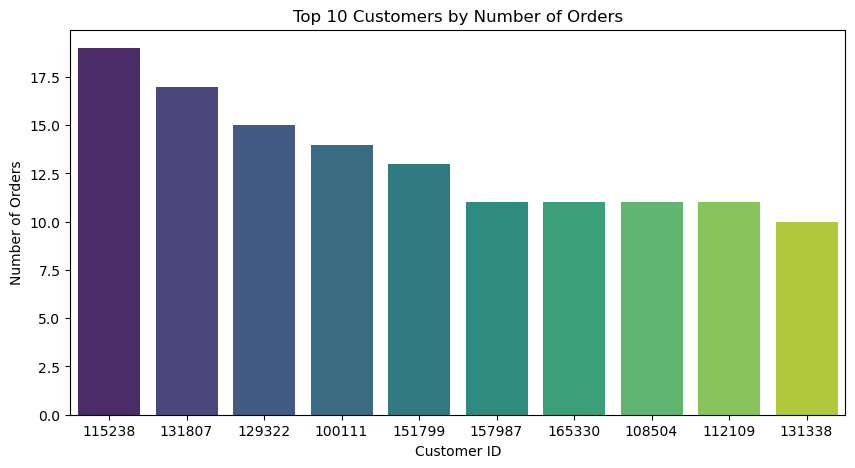

In [56]:
plt.figure(figsize=(10, 5))
sns.barplot(x=customer_orders.index, y=customer_orders.values, palette='viridis')
plt.title('Top 10 Customers by Number of Orders')
plt.xlabel('Customer ID')
plt.ylabel('Number of Orders')
plt.savefig("saved_plots/sales_trend.png")
plt.show()

-  Order frequency varies significantly over the past four-year period, with the most active customer (ID 115238) placing 19 orders, while regular customers typically order between 10-17 times. There is a core group of loyal, repeat purchasers, though no customer appears to order monthly (which would equate to 48 orders over four years). The distribution indicates opportunities to boost engagement among mid-frequency customers (those ordering 10-13 times) to match the habits of top performers (14-19 orders), potentially through targeted loyalty incentives or personalised marketing campaigns.

#### 3.2 Shipping Preferences: Which shipping method is most popular among customers?



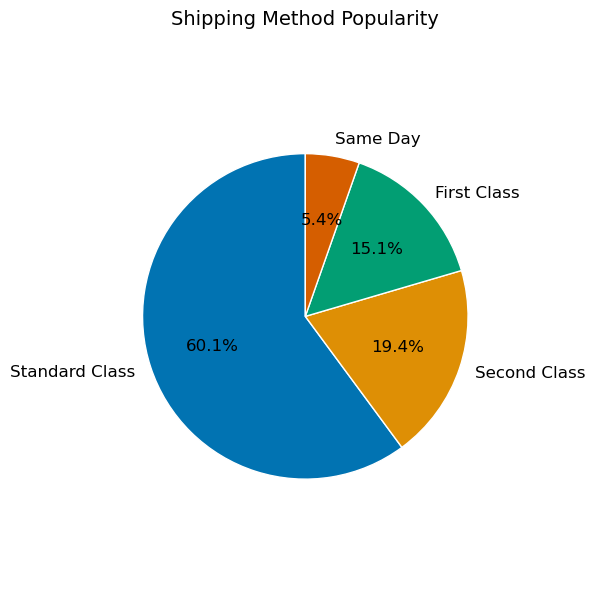

In [57]:
shipping_method = candy_df['Ship_Mode'].value_counts()

plt.figure(figsize=(6, 6))  
shipping_method.plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=sns.color_palette('colorblind'),
    startangle=90,  
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}, 
    textprops={'fontsize': 12}  
)

plt.title('Shipping Method Popularity', fontsize=14, pad=20)
plt.ylabel('')
plt.axis('equal')
plt.tight_layout()
plt.savefig("saved_plots/sales_trend.png")
plt.show()

Standard Class is by far the most popular option, accounting for the majority of orders (5,943), followed by Second Class (1,921) and First Class (1,491), while Same Day delivery is the least utilised (531 orders). Customers prioritise cost-effectiveness over speed, with expedited shipping methods (First Class and Same Day) representing less than 25% of total orders.

#### 4. Factory & Operational Efficiency


#### 4.1 Sales Performance: Which factory generates the highest total sales, and are there statistically significant differences in performance across factories?



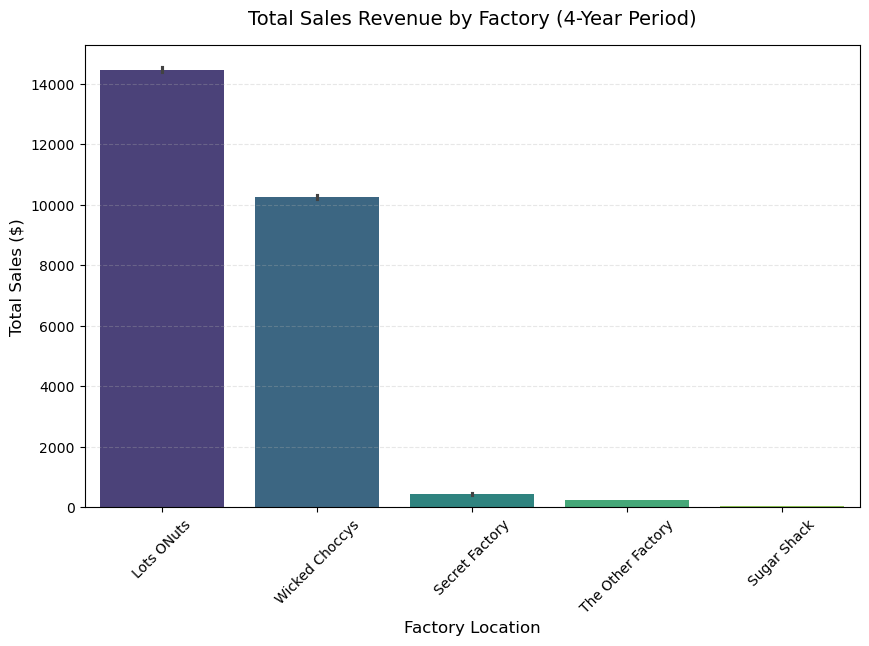

In [58]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Factory', y='Sales', data=candy_df, 
            estimator=sum, palette='viridis', 
            order=candy_df.groupby('Factory')['Sales'].sum().sort_values(ascending=False).index)
plt.title('Total Sales Revenue by Factory (4-Year Period)', fontsize=14, pad=15)
plt.xlabel('Factory Location', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.savefig("saved_plots/sales_trend.png")
plt.show()

- Lots Onuts is the most commercially successful facility, potentially due to superior production capacity, product range or market demand, whereas Sugar Shack may require strategic improvements to boost its sales performance. The clear hierarchy in revenue highlights opportunities to replicate best practices from top-performing factories across the network.


#### 4.2 Profitability Consistency: How does profit margin distribution vary across factories, and which demonstrate the most consistent profitability?



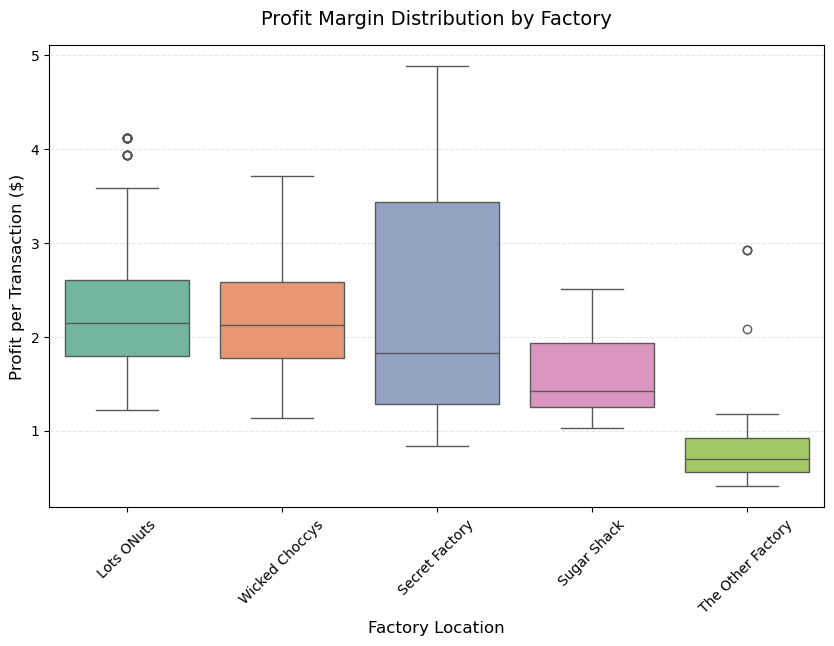

In [59]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Factory', y='Profit', data=candy_df, 
            palette='Set2',
            order=candy_df.groupby('Factory')['Profit'].median().sort_values(ascending=False).index)
plt.title('Profit Margin Distribution by Factory', fontsize=14, pad=15)
plt.xlabel('Factory Location', fontsize=12)
plt.ylabel('Profit per Transaction ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.savefig("saved_plots/sales_trend.png")
plt.show()

####  4.3 How do factory performance metrics vary across different countries ?


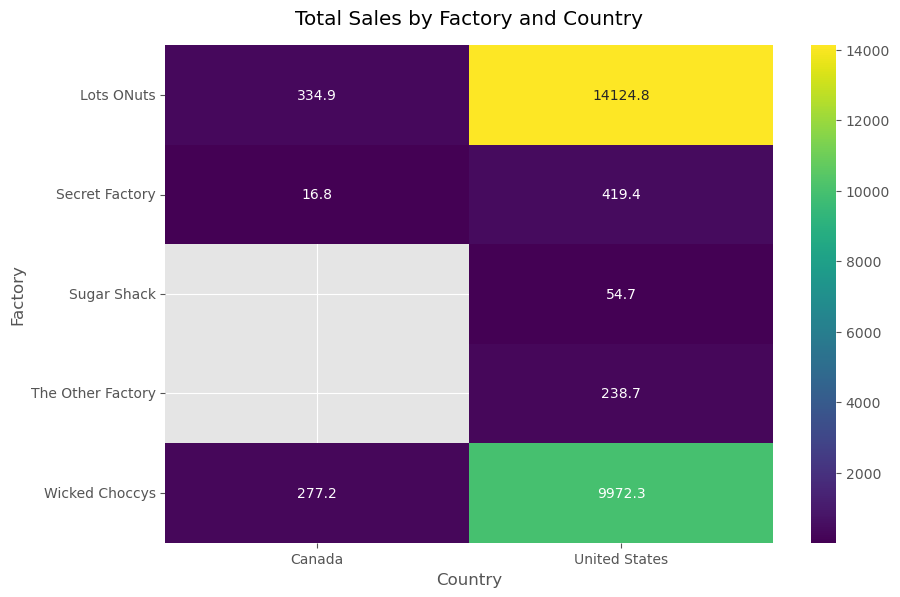

In [60]:
plt.style.use('ggplot')
plt.figure(figsize=(18, 12))


plt.subplot(2, 2, 1)
sales_by_factory = candy_df.groupby(['Factory', 'Country'])['Sales'].sum().unstack()
sns.heatmap(sales_by_factory, cmap='viridis', annot=True, fmt='.1f')  
plt.title('Total Sales by Factory and Country', pad=15)
plt.ylabel('Factory')
plt.xlabel('Country')
plt.tight_layout(pad=3)
plt.savefig("saved_plots/sales_trend.png")
plt.show()


The Wicked Choccys and Lots ONuts dominating US sales, while all factories show minimal performance in Canada. This suggests either significantly stronger market demand or better distribution channels in the United States. Particularly noteworthy is Secret Factory's dramatic disparity - achieving just 16.80 in Canada versus 419.40 in the US - indicating potential market-specific challenges or untapped opportunities in the Canadian market that warrant further investigation. Sugar Shack and The Other Factory, both, do not operate in Canada. 

#### 4.4 Shipping Efficiency: How does shipping efficiency vary across factories and countries?

Do certain factory-country combinations demonstrate significantly faster or more consistent shipping times compared to others?



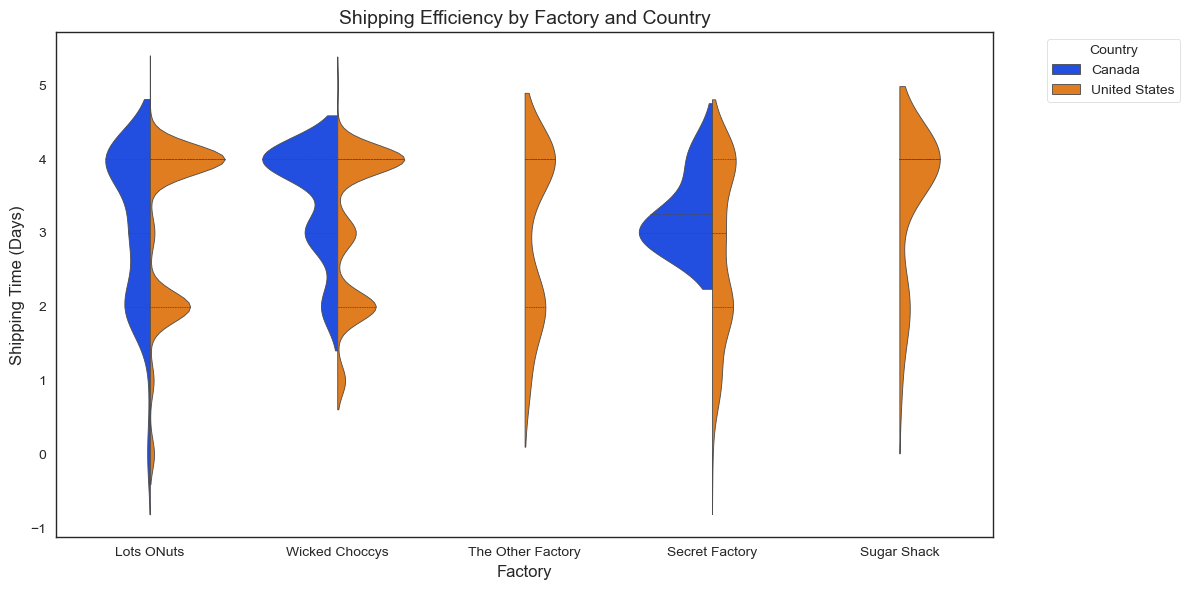

In [61]:
plt.figure(figsize=(12, 6))
sns.set_style("white")
ax = sns.violinplot(
    data=candy_df, 
    x='Factory', 
    y='Ship_Time', 
    hue='Country',
    split=True, 
    inner='quartile', 
    palette="bright"  
)

plt.title('Shipping Efficiency by Factory and Country', fontsize=14)
plt.xlabel('Factory', fontsize=12)
plt.ylabel('Shipping Time (Days)', fontsize=12)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("saved_plots/sales_trend.png")
plt.show()

# Hypothesis Test:

#### Hypothesis 1: Does Shipping Mode Affect Profitability?

Null Hypothesis (H0): Profit percentage is independent of shipping mode (no significant difference in mean profit across shipping methods).

Alternative Hypothesis (H1): Profit percentage differs significantly by shipping mode, with slower methods associated with lower profitability.

In [62]:
# Check variances
groups = [group['Profit'] for name, group in candy_df.groupby('Ship_Mode')]
print("Levene's Test for equal variances:")
print(stats.levene(*groups))

# If p-value > 0.05-- ANOVA
print("\nOne-way ANOVA Results:")
f_val, p_val = stats.f_oneway(*groups)
print("F-value:", f_val)
print("p-value:", p_val)

Levene's Test for equal variances:
LeveneResult(statistic=0.5720445232226682, pvalue=0.633366688273485)

One-way ANOVA Results:
F-value: 1.9430759376881575
p-value: 0.12029517919049425


In [63]:
if p_val < 0.05:
    print("\nReject H0: Significant evidence that shipping mode affects profitability (p = {:.3f}). Faster methods yield higher margins.".format(p_val))
else:
    print("\nFail to reject H0: No significant difference in profit margins across shipping methods (p = {:.3f}).".format(p_val))


Fail to reject H0: No significant difference in profit margins across shipping methods (p = 0.120).


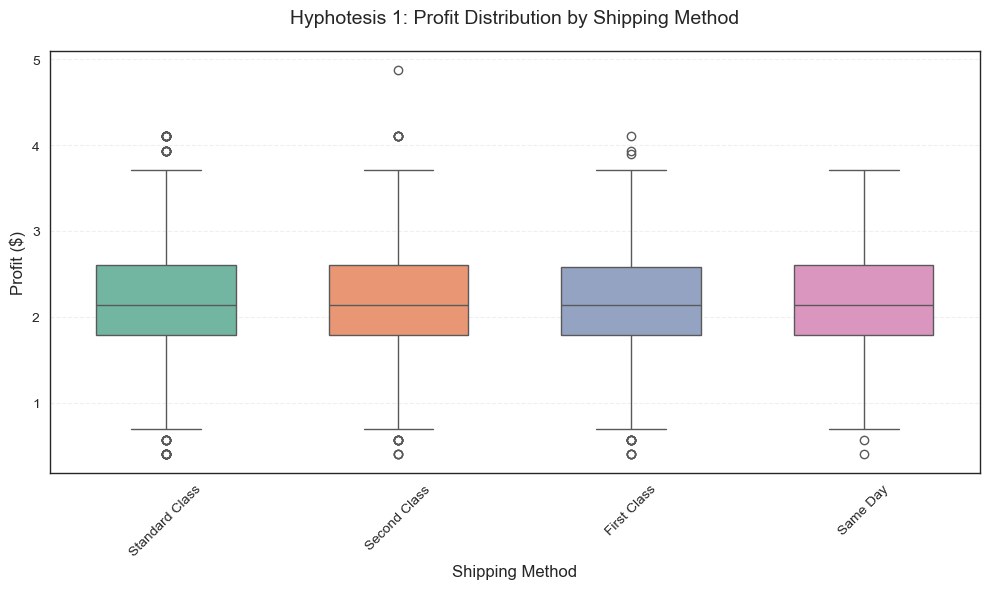

In [64]:
custom_blues = ['#a6cee3', '#1f78b4', '#3182bd', '#08519c']

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Ship_Mode', 
    y='Profit', 
    data=candy_df,
    palette= "Set2",  
    width=0.6  
   
)

plt.title('Hyphotesis 1: Profit Distribution by Shipping Method', pad=20, fontsize=14)
plt.xlabel('Shipping Method', fontsize=12)
plt.ylabel('Profit ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("saved_plots/sales_trend.png")
plt.show()

- Fail to reject H0: No significant difference in profit margins across shipping methods.
Shipping method choice does not substantially impact profit percentages. While slower methods may incur higher logistical costs, these are likely offset elsewhere in your pricing strategy or operational efficiency.  Faster shipping may justify premium pricing despite similar margins.


#### Hypothesis 2 - Do products with higher unit costs exhibit significantly different profit percentages compared to cheaper products?

- H0 (Null): No significant difference exists in profit percentages between low and high cost products
- H1 (Alternative): A statistically significant difference exists between low and high cost products

In [65]:
# Profit Percentage

candy_df['Profit_Pct'] = (candy_df['Profit'] / candy_df['Sales']) * 100

In [66]:
# cost group 
candy_df['Cost_Group'] = ['High' if x > candy_df['Cost_Per_Unit'].median() else 'Low' for x in candy_df['Cost_Per_Unit']]

In [67]:
# two-sample t-test

high_cost = candy_df[candy_df['Cost_Group'] == 'High']['Profit_Pct']
low_cost = candy_df[candy_df['Cost_Group'] == 'Low']['Profit_Pct']
t_stat, p_val = stats.ttest_ind(high_cost, low_cost, equal_var=False)

In [68]:
# Rresults

median_cost = candy_df['Cost_Per_Unit'].median()
print(f"Median Unit Cost: {median_cost:.2f}")
print(f"High Cost Products (n={len(high_cost)}): Mean Profit % = {high_cost.mean():.1f}%")
print(f"Low Cost Products (n={len(low_cost)}): Mean Profit % = {low_cost.mean():.1f}%")
print(f"\nT-test Results: t = {t_stat:.2f}, p = {p_val:.4f}")

Median Unit Cost: 1.14
High Cost Products (n=4471): Mean Profit % = 84.0%
Low Cost Products (n=5415): Mean Profit % = 86.0%

T-test Results: t = -14.90, p = 0.0000


In [69]:
if p_val < 0.05:
    print("\nReject H0: There is a statistically significant difference in profit percentages between low and high cost products (p = {:.4f}).".format(p_val))
else:
    print("\nFail to reject H0: No significant difference in profit percentages was found between the cost groups (p = {:.4f}).".format(p_val))



Reject H0: There is a statistically significant difference in profit percentages between low and high cost products (p = 0.0000).


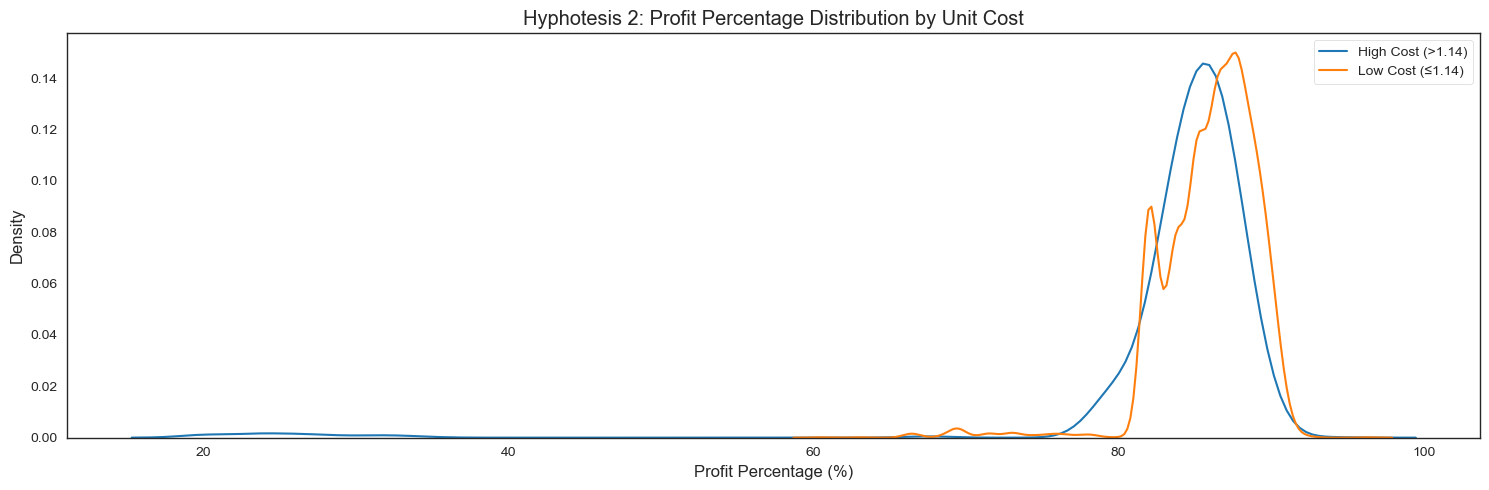

In [70]:
#  Visualisations

plt.figure(figsize=(15, 5))
sns.kdeplot(high_cost, label=f'High Cost (>{median_cost:.2f})', color='#1f77b4')
sns.kdeplot(low_cost, label=f'Low Cost (≤{median_cost:.2f})', color='#ff7f0e')
plt.title('Hyphotesis 2: Profit Percentage Distribution by Unit Cost')
plt.xlabel('Profit Percentage (%)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.savefig("saved_plots/sales_trend.png")
plt.show()

There is a statistically significant difference in profit percentages between low and high cost products. 
- Low-cost products deliver higher profit margins (86.0% vs. 84.0%), despite their lower price point.
- HighCost products generate slightly reduced margins, likely due to higher production or procurement expenses.

systemic advantages in the lower-cost segment—possibly due to better economies of scale, pricing flexibility or reduced waste. This warrants review of pricing strategies for high-cost items to narrow the gap.
The 2 percentage point margin gap you found (86% vs 84%), while seem small, it could represent substantial absolute profit gains when scaled across all transactions.

## Machine Learning 

In [71]:
candy_reg = candy.copy(deep=True)

#### drop columns unwanted:



In [72]:
candy_reg.drop(columns=[
    'OrderID', 'Order_Date', 'CustomerID', 
    'Country', 'State', 'Qty', 'Cost', 'Profit'
], inplace=True)

In [73]:
candy_reg.columns

Index(['Ship_Mode', 'Category', 'Region', 'Product', 'Sales', 'Factory',
       'Ship_Time', 'Order_Day', 'Order_Month', 'Order_Year',
       'Order_DayOfWeek', 'Order_Quarter', 'Customer_Order_Count',
       'Sales_Per_Customer', 'Customer_Tenure', 'Is_Bulk_Order', 'Product_Age',
       'Is_Holiday', 'Order_Month_sin', 'Order_DayOfWeek_cos',
       'Price_Per_Unit', 'Cost_Per_Unit'],
      dtype='object')

In [74]:
candy_reg.nunique()

Ship_Mode                  4
Category                   3
Region                     4
Product                   15
Sales                     82
Factory                    5
Ship_Time                  6
Order_Day                 31
Order_Month               12
Order_Year                 4
Order_DayOfWeek            7
Order_Quarter              4
Customer_Order_Count      16
Sales_Per_Customer      1360
Customer_Tenure            5
Is_Bulk_Order              2
Product_Age              885
Is_Holiday                 2
Order_Month_sin           11
Order_DayOfWeek_cos        7
Price_Per_Unit            16
Cost_Per_Unit             21
dtype: int64

### Encoding Categorical Features: 

TO be able fit ML models, Categircal features will be anconded :

- Ship Mode will be encode using One-Hot Encoding = Small number of categories, no ordinal relationship
- Category will be encode using One-Hot Encoding = 	Compact set, equal importance, no order
- Region will be encode using One-Hot Encoding = Nominal and low cardinality
- Product will be encode using  Ordinal/Label	Depends = as there are higher number of atribuites (15)
- Factory	will be encode using One-Hot Encoding = Again, nominal with low cardinality

Tree-based models ( XGBoost, Random Forest) can handle label encoding well, even if there's no real ordinal relationship.

Linear models (Logistic Regression, SVM): Prefer One-Hot Encoding to avoid implicit ordinal relationships.

In [75]:
# One-Hot Encoding

candy_reg = pd.get_dummies(candy_reg, columns=['Ship_Mode', 'Category', 'Region', 'Factory'], drop_first= False)


In [76]:
# Label encoding for Product Name

product_means = candy_reg.groupby('Product')['Sales'].mean().to_dict()
candy_reg['Product_Name'] = candy_reg['Product'].map(product_means)
candy_reg.drop('Product', axis=1, inplace=True)

In [77]:
candy_reg.head()

,Sales,Ship_Time,Order_Day,Order_Month,Order_Year,Order_DayOfWeek,Order_Quarter,Customer_Order_Count,Sales_Per_Customer,Customer_Tenure,Is_Bulk_Order,Product_Age,Is_Holiday,Order_Month_sin,Order_DayOfWeek_cos,Price_Per_Unit,Cost_Per_Unit,Ship_Mode_First Class,Ship_Mode_Same Day,Ship_Mode_Second Class,Ship_Mode_Standard Class,Category_Chocolate,Category_Sugar,Category_Sugar Free,Region_Atlantic,Region_Gulf,Region_Interior,Region_Pacific,Factory_Lots ONuts,Factory_Secret Factory,Factory_Sugar Shack,Factory_The Other Factory,Factory_Wicked Choccys,Product_Name
0,4.795791,3,19,8,2021,3,3,3,83.490000,1096,0,90.0,0,-0.866025,-0.900969,20.00,10.00,False,False,False,True,True,False,False,True,False,False,False,True,False,False,False,False,2.531629
2,4.795791,3,19,8,2024,0,3,3,83.490000,1096,0,714.0,0,-0.866025,1.000000,20.00,10.00,False,False,False,True,True,False,False,True,False,False,False,True,False,False,False,False,2.531629
3,4.795791,3,21,1,2021,3,1,19,43.486842,1095,0,5.0,0,0.500000,-0.900969,20.00,10.00,False,False,False,True,True,False,False,True,False,False,False,True,False,False,False,False,2.590827
4,2.374906,2,6,1,2021,2,1,1,9.750000,0,0,2.0,0,0.500000,-0.222521,3.25,1.14,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,True,2.586543
5,2.915064,4,13,1,2021,2,1,3,14.483333,0,0,3.0,0,0.500000,-0.222521,3.49,1.00,False,False,False,True,True,False,False,False,False,False,True,True,False,False,False,False,2.531629


## Split the data - Train and Test 

In [78]:
X = candy_reg.drop(columns=['Sales'])
y = candy_reg['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Scaling the Features
- Some models (like Ridge and Lasso) can benefit from feature scaling, so I will scale the data accordingly. Decision Trees, Gradient Boosting and Random Forest don’t require scaling.

In [79]:
scaler = StandardScaler()
X_train_scalled = scaler.fit_transform(X_train)
X_test_scalled = scaler.transform(X_test)

Train Models:

Linear Regression – I’ll use this as a simple starting point to compare with other models. Since the data isn’t very linear, I expect it won’t perform as well as more complex models. Linear Regression works best when there’s a straight-line relationship between features and the target. It doesn’t need any tuning.

Ridge Regression – This is similar to Linear Regression but more stable. It reduces overfitting by penalising large coefficients. However, I still expect it to perform poorly compared to other models.

Decision Tree Regressor – Decision Trees can find complex, non-linear patterns . They work well with different data types (numbers, categories, etc.). I’ve set max_depth=10 to balance accuracy and overfitting. Decision Trees split data into smaller groups and make predictions for each, but they can overfit if not controlled.

Random Forest Regressor – This improves on Decision Trees by combining many trees, making predictions more reliable. It handles noise and complex patterns well. I’ve set n_estimators=100 (the number of trees) for a good balance between performance and speed. Random Forest usually works better than a single Decision Tree.

Gradient Boosting Regressor – This model builds trees one after another, fixing errors from previous steps. It often performs better than Random Forest, especially when some features are more important than others.

In [80]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(max_depth=8, n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}


#### Fit, Predict and Evaluate the models :

In [81]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    # Fit model
    model.fit(X_train_scalled, y_train)

    # Predict
    y_train_pred = model.predict(X_train_scalled)
    y_test_pred = model.predict(X_test_scalled)

    # Evaluate
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error')
    
    print(f" {name} Results:")
    print(f"Train RMSE: {train_rmse:.4f}, R2: {train_r2:.4f}")
    print(f"Test RMSE:  {test_rmse:.4f}, R2: {test_r2:.4f}")
    print(f"CV RMSE:    {(-cv_scores.mean()):.4f} +- {cv_scores.std():.4f}\n")


 Linear Regression Results:
Train RMSE: 0.4111, R2: 0.4356
Test RMSE:  0.4035, R2: 0.4650
CV RMSE:    0.3816 +- 0.0034

 Ridge Regression Results:
Train RMSE: 0.3801, R2: 0.5176
Test RMSE:  0.3806, R2: 0.5240
CV RMSE:    0.3816 +- 0.0033

 Decision Tree Results:
Train RMSE: 0.3045, R2: 0.6903
Test RMSE:  0.3370, R2: 0.6269
CV RMSE:    0.3386 +- 0.0037

 Random Forest Results:
Train RMSE: 0.3106, R2: 0.6779
Test RMSE:  0.3170, R2: 0.6698
CV RMSE:    0.3238 +- 0.0047

 Gradient Boosting Results:
Train RMSE: 0.3158, R2: 0.6670
Test RMSE:  0.3165, R2: 0.6708
CV RMSE:    0.3228 +- 0.0053



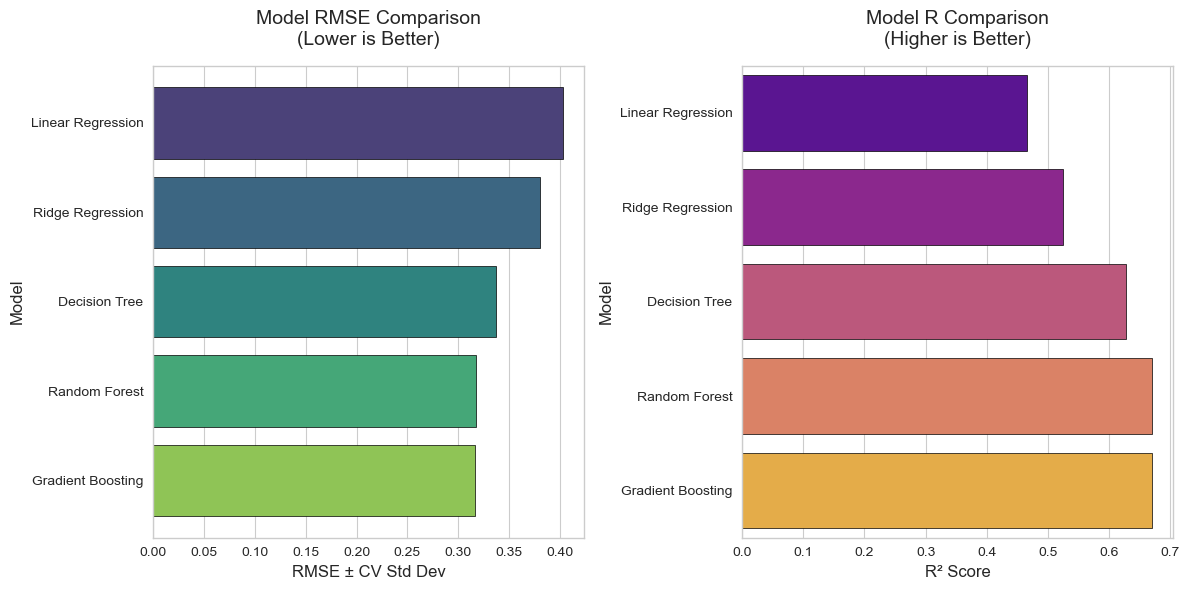

In [82]:
# Plotting the resutls (to be add to the report)

results = []
for name, model in models.items():
    model.fit(X_train_scalled, y_train)
    y_pred = model.predict(X_test_scalled)
    
    results.append({
        'Model': name,
        'Train RMSE': mean_squared_error(y_train, model.predict(X_train_scalled), squared=False),
        'Test RMSE': mean_squared_error(y_test, y_pred, squared=False),
        'Train R2': r2_score(y_train, model.predict(X_train_scalled)),
        'Test R2': r2_score(y_test, y_pred),
        'CV RMSE Mean': -cross_val_score(model, X, y, cv=kf, 
                                      scoring='neg_root_mean_squared_error').mean(),
        'CV RMSE Std': cross_val_score(model, X, y, cv=kf, 
                                    scoring='neg_root_mean_squared_error').std()
    })

results_df = pd.DataFrame(results)

# 2. Plot RMSE Comparison
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# RMSE Plot
plt.subplot(1, 2, 1)
sns.barplot(data=results_df, y='Model', x='Test RMSE', 
            palette="viridis", edgecolor='black')
plt.errorbar(x=results_df['Test RMSE'], 
             y=results_df['Model'],
             fmt='none', c='black', capsize=5)
plt.title("Model RMSE Comparison\n(Lower is Better)", fontsize=14, pad=15)
plt.xlabel("RMSE ± CV Std Dev", fontsize=12)

# R2 Plot
plt.subplot(1, 2, 2)
sns.barplot(data=results_df, y='Model', x='Test R2', 
            palette="plasma", edgecolor='black')
plt.title("Model R Comparison\n(Higher is Better)", fontsize=14, pad=15)
plt.xlabel("R² Score", fontsize=12)

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [83]:
# Tabular Summary (to be added to the report)

display(results_df.style
       .background_gradient(subset=['Test RMSE'], cmap='viridis_r')
       .background_gradient(subset=['Test R2'], cmap='plasma')
       .format({'Train RMSE': '{:.3f}', 'Test RMSE': '{:.3f}',
                'Train R2': '{:.3f}', 'Test R2': '{:.3f}',
                'CV RMSE Mean': '{:.3f}', 'CV RMSE Std': '{:.3f}'}))




,Model,Train RMSE,Test RMSE,Train R2,Test R2,CV RMSE Mean,CV RMSE Std
0,Linear Regression,0.411,0.404,0.436,0.465,0.382,0.003
1,Ridge Regression,0.380,0.381,0.518,0.524,0.382,0.003
2,Decision Tree,0.305,0.337,0.690,0.627,0.339,0.004
3,Random Forest,0.311,0.317,0.678,0.670,0.324,0.005
4,Gradient Boosting,0.316,0.317,0.667,0.671,0.323,0.005


#### Model Performance Interpretation

- Linear Regression Results
The linear regression model shows moderate performance.It explains about 43.6% of the variance in the data. The test set performs slightly better, with 46.5%, suggesting the model generalises reasonably well. The cross-validation RMSE is 0.3816 +- 0.0034, which is better than the training and test RMSE, indicating that the model is stable across different data splits. However, the relatively low R suggests that a linear model may not capture all the patterns in the data.

- Ridge Regression Results
Ridge regression improves upon linear regression by adding regularisation to reduce overfitting. The training RMSE is 0.3801, and the R is 51.7%, showing better performance than standard linear regression. The test RMSE and R are very close to the training scores, meaning the model generalises well. The CV RMSE (0.3816 +- 0.0033) is consistent with the test results, confirming the model’s stability. Ridge regression performs better than linear regression, likely due to its ability to handle multicollinearity and prevent overfitting.

- Decision Tree Results
The decision tree model performs well on the training set, with an RMSE of 0.3045 and an R of 69%, indicating strong predictive ability. However, the test RMSE (0.3370) is higher, and the R drops to 62.6%, suggesting some overfitting. The CV RMSE (0.3386 +- 0.0037) aligns with the test results, confirming that the model’s performance is consistent but slightly worse than on the training data. While decision trees capture complex patterns, they can overfit if not properly controlled.

- Random Forest Results
The random forest model improves over the decision tree by combining multiple trees, reducing overfitting. The training RMSE is 0.3106, with an R of 69.7% , while the test RMSE and R are very close, showing good generalisation. The CV RMSE (0.3238 +- 0.0047) is slightly higher than the test RMSE but still consistent, indicating stable performance. Random forests provide a good balance between bias and variance, making them reliable for prediction.

- Gradient Boosting Results
Gradient boosting is another ensemble method that performs well. The training RMSE is 0.3158, with an R of 66.7%, while the test RMSE and R are nearly identical, showing excellent generalisation. The CV RMSE (0.3228 +- 0.0053) is slightly higher but still consistent, confirming the model’s robustness. Gradient boosting often outperforms random forests by sequentially correcting errors, making it one of the best-performing models here.


- Linear and ridge regression are decent but limited in capturing complex patterns. Decision trees perform well but may overfit. Random forests and gradient boosting are the best, with gradient boosting slightly outperforming due to better generalisation and stability.


- Next, I will use gradient boosting to make the model better.
This method builds models step by step, fixing errors as it goes, which often leads to stronger predictions. Since it performed well in earlier tests, it’s a good choice for improving accuracy.

#### Hyperparameter Tuning for Tree-Based Models

Since the tree-based models (Decision Tree, Random Forest, and Gradient Boosting) performed better than the linear models, I will focus on tuning them to improve their performance further.

Decision Tree: Works well but shows some overfitting (test performance is worse than training). Tuning may help reduce this gap.
Random Forest: Performs strongly but might still be improved with better hyperparameter settings.
Gradient Boosting: Generalises well (train and test results are almost the same), but fine-tuning could make it even better.


#### Gradient Boosting Grid Search

In [84]:
gb = GradientBoostingRegressor(random_state=42)

param_grid = {
    'n_estimators': [500, 1000],  
    'learning_rate': [0.005, 0.01, 0.05, 0.1], 
    'max_depth': [3, 4], 
    'max_features': [0.8, 'sqrt'],
    'min_samples_leaf': [2, 5, 10], 
    'subsample': [0.8, 0.9]  
}


grid_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_gb.fit(X_train, y_train)
print(" Best GB Parameters:", grid_gb.best_params_)
print(" Best CV RMSE:", -grid_gb.best_score_)


Fitting 5 folds for each of 192 candidates, totalling 960 fits
 Best GB Parameters: {'learning_rate': 0.01, 'max_depth': 4, 'max_features': 0.8, 'min_samples_leaf': 2, 'n_estimators': 1000, 'subsample': 0.9}
 Best CV RMSE: 0.3211395563273638


#### Random Forest Grid Search

In [85]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [15, 20, None], 
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 0.5, 0.7],  
    'bootstrap': [True] 
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_rf.fit(X_train, y_train)
print(" Best RF Parameters:", grid_rf.best_params_)
print(" Best CV RMSE:", -grid_rf.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
 Best RF Parameters: {'bootstrap': True, 'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 4, 'n_estimators': 500}
 Best CV RMSE: 0.33305217525829717


#### Decision Tree Grid Search

In [86]:
dt = DecisionTreeRegressor(random_state=42)

dt_param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 5, 10]
}

grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=dt_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

print("Fitting Decision Tree...")
grid_dt.fit(X_train, y_train)

Fitting Decision Tree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [3, 5, 10],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_root_mean_squared_error', verbose=2)

#### Modedels Evaluations 

In [87]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test, cv=5):
    # Fit model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # CV RMSE
    cv_rmse = -cross_val_score(model, X_train, y_train, 
                               scoring='neg_root_mean_squared_error', 
                               cv=cv, n_jobs=-1)
    
    print(f" {name} Results:")
    print(f"Train RMSE: {train_rmse:.4f}, R2: {train_r2:.4f}")
    print(f"Test RMSE:  {test_rmse:.4f}, R2: {test_r2:.4f}")
    print(f"CV RMSE:    {cv_rmse.mean():.4f} +- {cv_rmse.std():.4f}")
    print("-" * 50)


In [88]:
# Get the best models from grid search
best_gb = grid_gb.best_estimator_
best_rf = grid_rf.best_estimator_
best_dt = grid_dt.best_estimator_


# Evaluate them
evaluate_model("Gradient Boosting", best_gb, X_train, y_train, X_test, y_test)
evaluate_model("Random Forest", best_rf, X_train, y_train, X_test, y_test)
evaluate_model("Decision Tree", best_dt, X_train, y_train, X_test, y_test)



 Gradient Boosting Results:
Train RMSE: 0.3033, R2: 0.6928
Test RMSE:  0.3136, R2: 0.6769
CV RMSE:    0.3211 +- 0.0094
--------------------------------------------------
 Random Forest Results:
Train RMSE: 0.2629, R2: 0.7691
Test RMSE:  0.3255, R2: 0.6520
CV RMSE:    0.3331 +- 0.0080
--------------------------------------------------
 Decision Tree Results:
Train RMSE: 0.3233, R2: 0.6510
Test RMSE:  0.3231, R2: 0.6570
CV RMSE:    0.3350 +- 0.0086
--------------------------------------------------


#### Plotting resutls to be used in the report

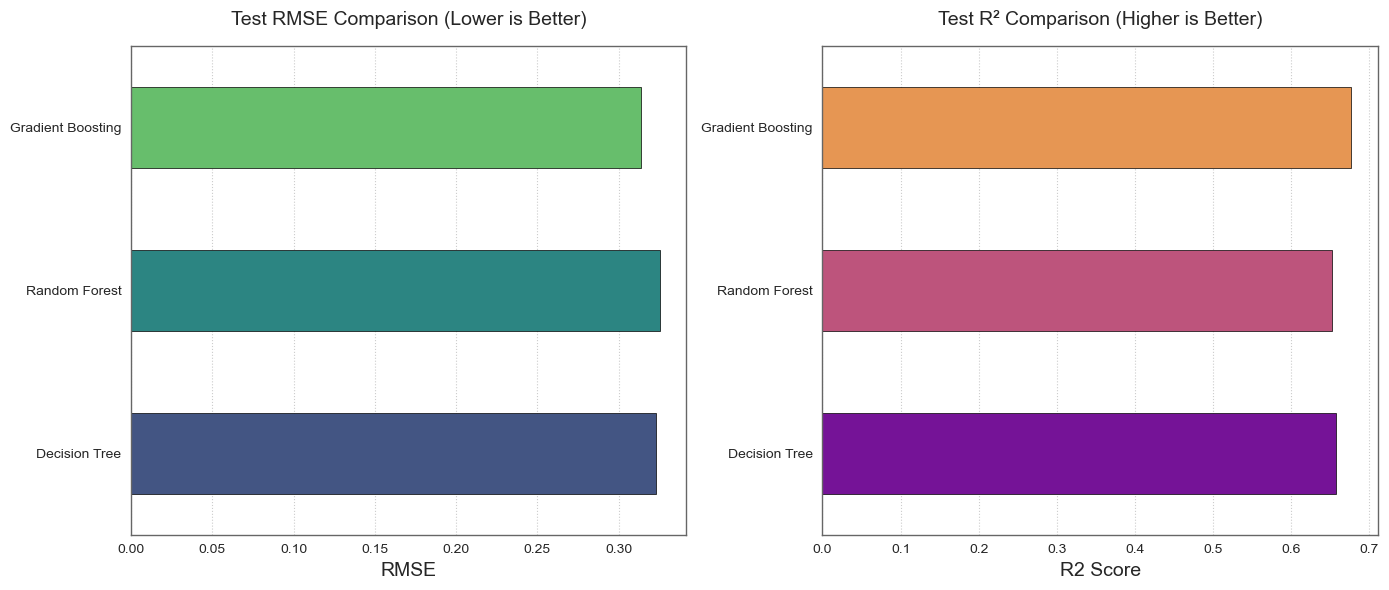

In [112]:
# Store results
results = []
models = {
    "Gradient Boosting": best_gb,
    "Random Forest": best_rf,
    "Decision Tree": best_dt
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    cv_rmse = -cross_val_score(model, X_train, y_train, 
                             scoring='neg_root_mean_squared_error', cv=5)
    
    results.append({
        'Model': name,
        'Train RMSE': mean_squared_error(y_train, model.predict(X_train), squared=False),
        'Test RMSE': mean_squared_error(y_test, y_test_pred, squared=False),
        'Train R2': r2_score(y_train, model.predict(X_train)),
        'Test R2': r2_score(y_test, y_test_pred),
        'CV RMSE Mean': cv_rmse.mean(),
        'CV RMSE Std': cv_rmse.std()
    })

results_df = pd.DataFrame(results)

# Set style
sns.set_style("whitegrid", {'grid.linestyle': ':', 'axes.edgecolor': '0.4'})
plt.figure(figsize=(14, 6))

# RMSE Plot
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=results_df, y='Model', x='Test RMSE', 
                 palette="viridis_r", saturation=0.8,
                 width=0.5, edgecolor='black', linewidth=0.5)
plt.title("Test RMSE Comparison (Lower is Better)", fontsize=14, pad=15)
plt.xlabel("RMSE", fontsize=14)
plt.ylabel("")

# R2 Plot
plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=results_df, y='Model', x='Test R2', 
                 palette="plasma_r", saturation=0.8,
                 width=0.5, edgecolor='black', linewidth=0.5)
plt.title("Test R² Comparison (Higher is Better)", fontsize=14, pad=15)
plt.xlabel("R2 Score", fontsize=14)
plt.ylabel("")
plt.tight_layout()
plt.show()

In [91]:
# Tabular results 

results_display = results_df.set_index('Model')
results_display = results_display[['Train RMSE', 'Test RMSE', 'CV RMSE Mean', 'CV RMSE Std', 'Train R2', 'Test R2']]
results_display.style \
    .format('{:.3f}') \
    .background_gradient(subset=['Test RMSE', 'CV RMSE Mean'], cmap='viridis_r') \
    .background_gradient(subset=['Test R2'], cmap='plasma_r')




,Train RMSE,Test RMSE,CV RMSE Mean,CV RMSE Std,Train R2,Test R2
Model,,,,,,
Gradient Boosting,0.303,0.314,0.321,0.009,0.693,0.677
Random Forest,0.263,0.325,0.333,0.008,0.769,0.652
Decision Tree,0.323,0.323,0.335,0.009,0.651,0.657


#### Model Performance Interpretation

After applying hyperparameter tuning:

- Gradient Boosting Performance
The Gradient Boosting model shows a good balance between performance on the training and test data. The training RMSE (0.3033) and test RMSE (0.3136) are close, suggesting the model generalises well without overfitting. The R scores (0.6928 train, 0.6769 test) indicate that the model explains around 69% of the variance in the training data and 68% in the test data, which is decent. The cross-validation RMSE (0.3211 +- 0.0094) is slightly higher than the test RMSE but still consistent, meaning the model performs reliably across different data splits. Overall, Gradient Boosting is a strong candidate, as it maintains good accuracy while avoiding overfitting.

- Random Forest Performance
The Random Forest model has a lower training RMSE (0.2629) compared to Gradient Boosting, suggesting it fits the training data better. However, the test RMSE (0.3255) is higher than its training RMSE, indicating slight overfitting. The R scores (0.7691 train, 0.6520 test) show a bigger drop than Gradient Boosting, meaning the model loses more performance on unseen data. The cross-validation RMSE (0.3331 +- 0.0080) is also slightly higher than the test RMSE, reinforcing that the model may not generalise as well as Gradient Boosting. 

- Decision Tree Performance
The Decision Tree model has the highest training RMSE (0.3233) among the three, meaning it doesn’t fit the training data as well as Random Forest or Gradient Boosting. However, the test RMSE (0.3231) is almost the same as the training RMSE, suggesting little to no overfitting. The R scores (0.6510 train, 0.6570 test) are the lowest, explaining only about 65% of the variance in the data. The cross-validation RMSE (0.3350 +- 0.0086) is slightly worse than the test RMSE, showing some inconsistency in performance across different data splits. While the Decision Tree is simpler and avoids overfitting, it is the weakest model in terms of overall predictive power.

##### - Conclusion
Gradient Boosting is the best-performing model, with strong and consistent results across training, testing and cross-validation. Random Forest fits the training data well but shows signs of slight overfitting. The Decision Tree, while stable, has the weakest predictive performance. As the goal is a reliable and accurate model, Gradient Boosting is the best choice.



#### Feature Importances Using Gradient Boosting Regressor (best performance)

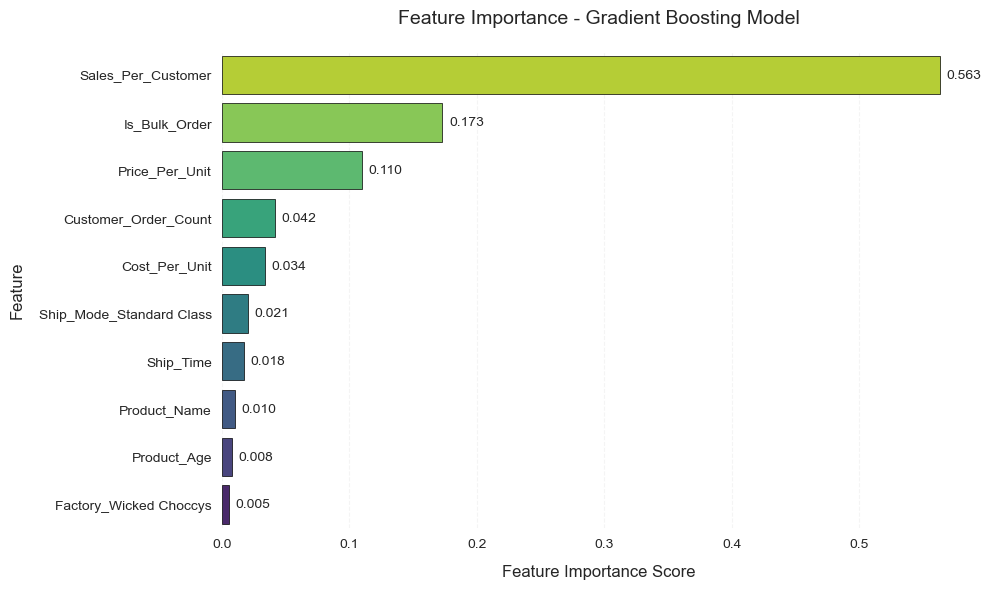

In [102]:
feature_importances = best_gb.feature_importances_
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False).head(10)  

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=features_df,
    x='Importance',
    y='Feature',
    palette="viridis_r",
    saturation=0.8,
    edgecolor='black',
    linewidth=0.5
)

plt.title(
    "Feature Importance - Gradient Boosting Model",
    fontsize=14,
    pad=20
)
plt.xlabel(
    "Feature Importance Score",
    fontsize=12,
    labelpad=10
)
plt.ylabel(
    "Feature",
    fontsize=12,
    labelpad=10
)

for i, (_, row) in enumerate(features_df.iterrows()):
    ax.text(
        row['Importance'] + 0.005,  
        i,                           
        f"{row['Importance']:.3f}",  
        va='center',                 
        ha='left',                   
        fontsize=10
    )

sns.despine(left=True, bottom=True)
ax.xaxis.grid(True, linestyle='--', alpha=0.2)
ax.yaxis.grid(False)

plt.tight_layout()
plt.show()

- The most accurate model (Gradient Boosting Regressor) shows which features have the biggest impact on the predictions. The model relies most on sales per customer, bulk orders, and price per unit, while other factors have much smaller effects. The top feature is Sales_Per_Customer. How much each customer spends is a key factor in the model’s decisions. The second most important feature indicates whether an order is bulk or not, it plays a significant role, though not as strong as sales per customer.

# Time Series Analysis: 

##### Goal:  DEMAND FORECASTING 
##### Predict future order quantities using ARIMA.

In [142]:
candy_timeseries = candy.copy(deep=True)

In [143]:
candy_timeseries = candy_timeseries.rename(columns={'Order Date': 'Order_Date','Units': 'Qty'})
candy_timeseries = candy_timeseries[['Order_Date', 'Qty']]

In [144]:
# Set 'Date' as index and sort in chronological order

candy_timeseries = candy_timeseries.set_index('Order_Date').sort_index()

In [145]:
# Convert the index (Order_Date) to datetime

candy_timeseries.index = pd.to_datetime(candy_timeseries.index, format='%d %m %Y')
candy_timeseries = candy_timeseries.sort_index()

In [146]:
# Index in datetime format
candy_timeseries.index = pd.to_datetime(candy_timeseries.index)
candy_demand = candy_timeseries.resample('M').sum()

# Time Series Visualisation:

Time Series Plot to analyse the raw data and identify overall trends, seasonality patterns and anomalies.

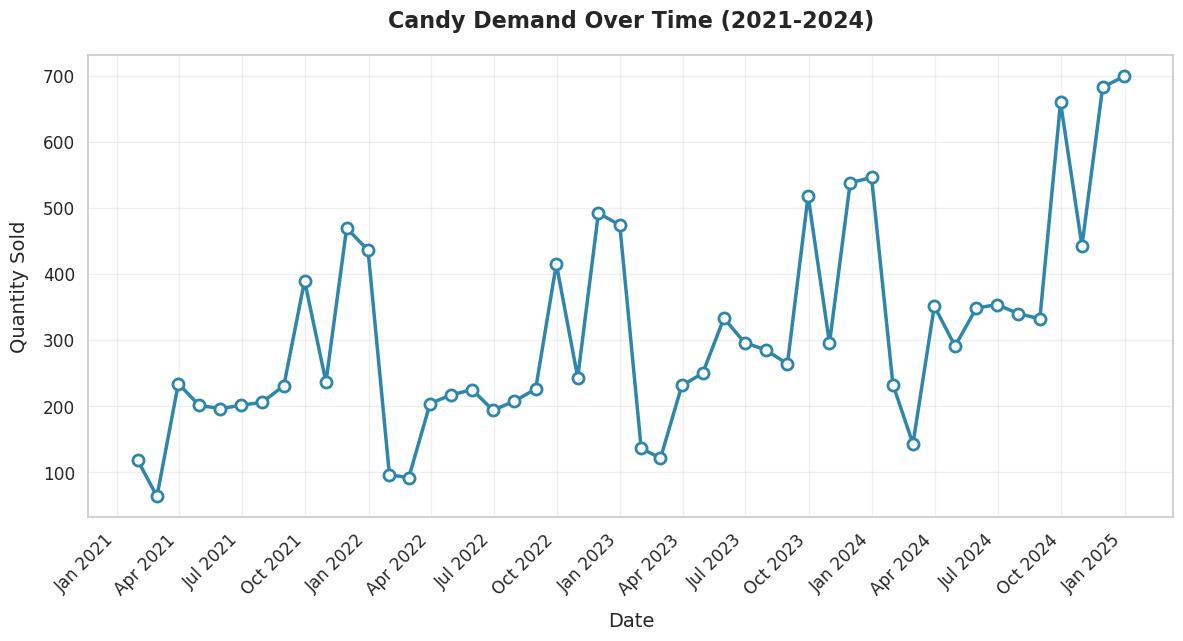

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set style
sns.set(style='whitegrid', font_scale=1.1)
plt.rcParams['font.family'] = 'DejaVu Sans'  

# Create figure
plt.figure(figsize=(14, 6))

# Plot 
ax = sns.lineplot(
    data=candy_demand,
    x=candy_demand.index,
    y='Qty',
    marker='o',
    markersize=8,
    color='#2E86AB',  
    linewidth=2.5,
    markerfacecolor='white',
    markeredgewidth=2,
    markeredgecolor='#2E86AB'
)

plt.title('Candy Demand Over Time (2021-2024)', fontsize=16, pad=20, fontweight='semibold')
plt.xlabel('Date', fontsize=14, labelpad=10)
plt.ylabel('Quantity Sold', fontsize=14, labelpad=10)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) 
plt.xticks(rotation=45, ha='right'); 

# Annual growth:

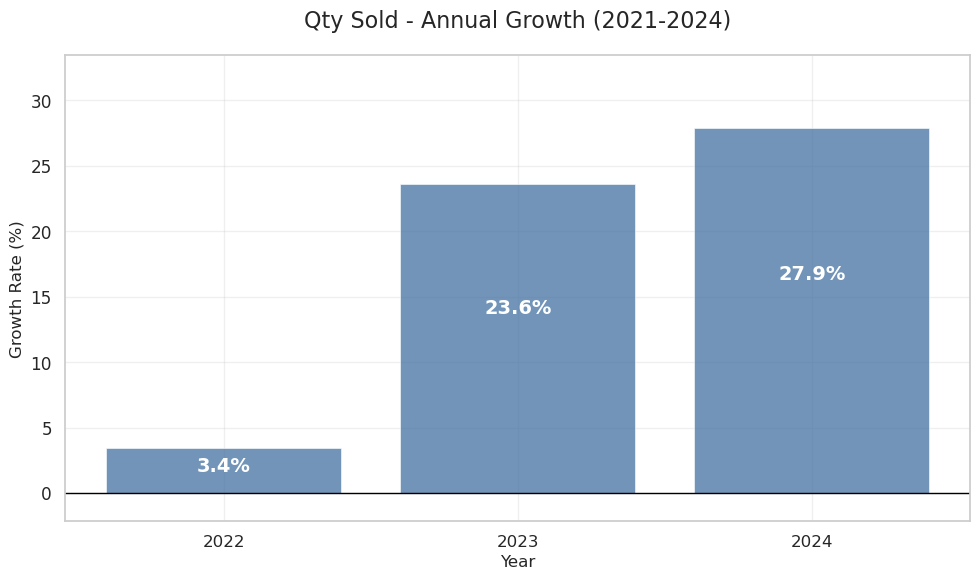

In [148]:
growth = candy_demand['Qty'].resample('Y').sum().pct_change().mul(100).dropna()
index = pd.to_datetime(['2021-01-01', '2022-01-01', '2023-01-01', '2024-01-01'])

plt.figure(figsize=(10, 6))
bars = plt.bar(growth.index.year, growth, 
               color='#4E79A7', 
               edgecolor='white', 
               linewidth=0.5, 
               alpha=0.8)

plt.axhline(0, color='black', linewidth=1)

y_margin = max(abs(growth)) * 0.2
plt.ylim(min(growth) - y_margin, max(growth) + y_margin)

for bar in bars:
    height = bar.get_height()
   
    label_y = height * 0.6 if height >= 0 else height * 0.8
    plt.text(bar.get_x() + bar.get_width()/2,
             label_y,
             f'{height:.1f}%',
             ha='center',
             va='center',  
             fontsize=14,
             fontweight='bold',
             color='white') 

plt.title('Qty Sold - Annual Growth (2021-2024)', fontsize=16, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Growth Rate (%)', fontsize=12)
plt.xticks(growth.index.year, labels=growth.index.year, rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

- The results show the annual growth in candy demand over three years: 2022, 2023, and 2024. In 2022, the growth rate was 3.42%, indicating a small but positive increase in candy sales compared to the previous year. By 2023, the growth rate jumped significantly to 23.58%, suggesting a much higher demand for candy that year. This could be due to factors like improved marketing, seasonal trends, or increased consumer spending. In 2024, the growth rate rose again to 27.86%, showing that the upward trend in candy demand continued at an even faster pace.

- Overall, the data reveals a clear pattern of accelerating growth in candy sales over the three-year period. The sharp increases in 2023 and 2024 suggest that the market for candy expanded rapidly, possibly due to changing consumer preferences, successful promotions, or broader economic conditions. These figures could help businesses plan production, stock levels, and marketing strategies to meet rising demand.

#### Decomposition

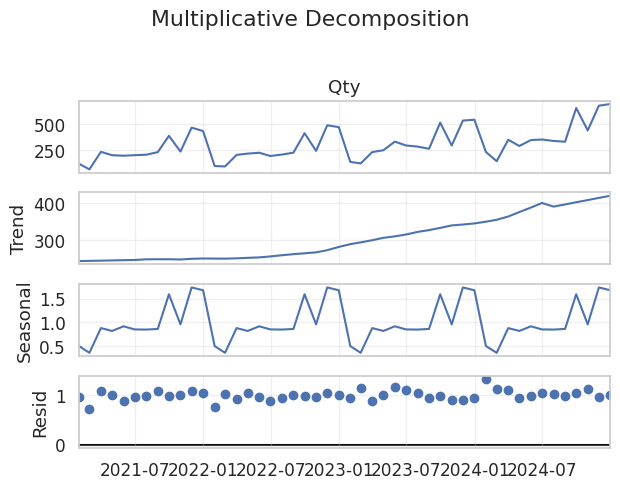

In [149]:
#Multiplicative decomposition 

decomposition = seasonal_decompose(
    candy_demand['Qty'],
    model='multiplicative',
    period=12, 
    extrapolate_trend='freq'  
)

decomposition.plot()
plt.suptitle('Multiplicative Decomposition', y=1.02)
plt.tight_layout()
plt.savefig("saved_plots/sales_trend.png")
plt.show()

In [150]:
#Check decomposition lengths and values:

print(len(decomposition.trend))         
print(decomposition.seasonal.head(12))   
print(decomposition.resid.describe()) 

48
Order_Date
2021-01-31    0.503379
2021-02-28    0.361875
2021-03-31    0.880172
2021-04-30    0.820253
2021-05-31    0.917711
2021-06-30    0.852069
2021-07-31    0.849311
2021-08-31    0.862217
2021-09-30    1.589201
2021-10-31    0.958217
2021-11-30    1.732275
2021-12-31    1.673319
Freq: ME, Name: seasonal, dtype: float64
count    48.000000
mean      0.997901
std       0.099437
min       0.719863
25%       0.946203
50%       0.992098
75%       1.042914
max       1.322434
Name: resid, dtype: float64


 the highest seasonal peaks occur in September, November and December, suggesting increased activity during these months. Meanwhile, the lowest values are in February and January, indicating quieter periods. This pattern suggests a strong yearly cycle, with a noticeable rise towards the end of the year.

#### Checking Stationary

Check if the time series is stationary (no trend/seasonality) using the Augmented Dickey-Fuller test (ADF test), where a p-value < 0.05 confirms stationarity (rejecting the null hypothesis of non-stationarity), Because stationary data is required for reliable ARIMA/SARIMA modeling


In [151]:
# Run the ADF test
adf_result = adfuller(candy_demand['Qty'])

# Print ADF statistic and p-value
print(f"ADF Statistic: {adf_result[0]:.3f}")
print(f"p-value: {adf_result[1]:.5f}")

ADF Statistic: -3.500
p-value: 0.00798


In [152]:
# Check for stationarity
if adf_result[1] < 0.05:
    print(" The time series is stationary.")
else:
    print(" The time series is NOT stationary.")

 The time series is stationary.


No need for regular differencing (d=0) as ADF test confirms stationarity.

#### Plot Correlation and Auto Correlation Plot 

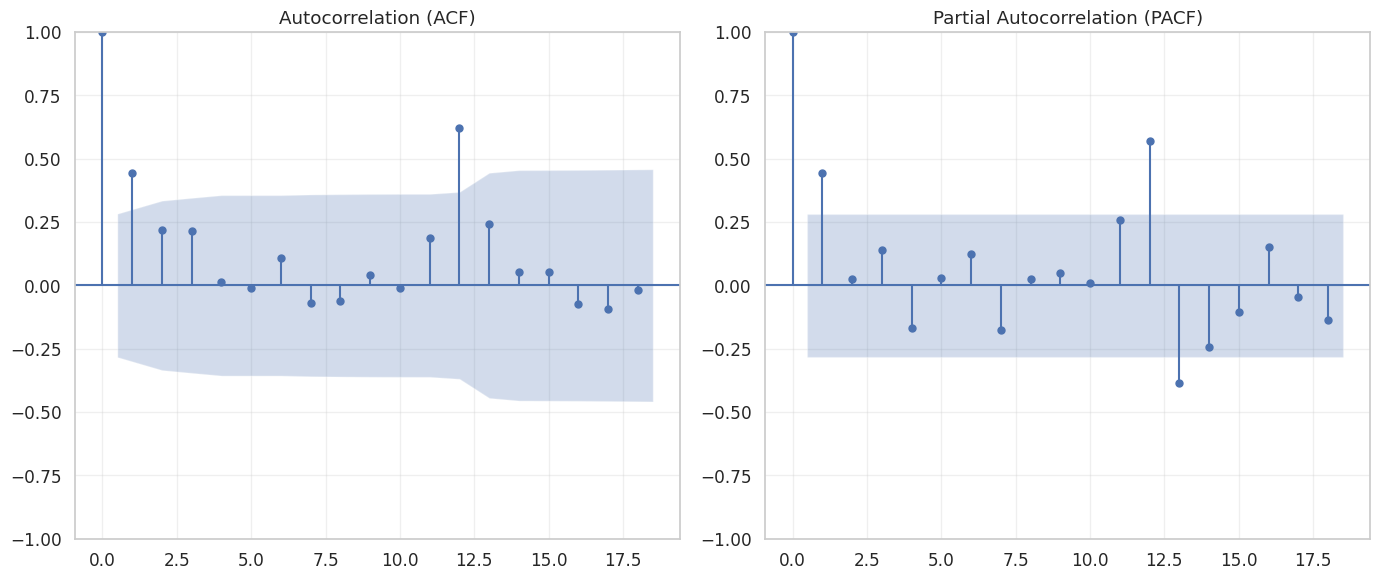

In [153]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set up plots
plt.figure(figsize=(14, 6))

# ACF plot
plt.subplot(1, 2, 1)
plot_acf(candy_demand['Qty'], lags=18, ax=plt.gca())
plt.title('Autocorrelation (ACF)')

# PACF plot
plt.subplot(1, 2, 2)
plot_pacf(candy_demand['Qty'], lags=18, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()

But seasonal differencing (D=1) still needed as the seasonal component (like yearly cycles) is strong.

 Interpretation of ACF (left plot)
Lag 1 has a strong positive correlation (~0.9): today's demand is highly related to last month's.

Lags 2 to 10 gradually drop but remain above the confidence interval at some points, which implies persisting autocorrelation — possibly due to trend or seasonality.

Notice the spike at lag 12: This is a key signal that you likely have annual seasonality (monthly data with a yearly cycle).

Conclusion: This pattern is non-random, showing clear temporal dependencies and seasonality.

Interpretation of PACF (right plot)

Big spike at lag 1 → a potential AR(1) process (past values directly influence current values).

Some other lags (like 10, 12, 15) also spike beyond the confidence interval — may suggest additional AR terms or seasonal effects.

Conclusion: There's strong evidence for autoregressive structure, and possibly seasonality too.

#### Seasonal differencing (lag 12)

As the time series is seasonal, and the seasonal component is defined by four parameters: (P, D, Q, s), checking seasonal differencing diff(12) is important to determine whether removing seasonality from the time series data makes it stationary. this next step  helps to remove the seasonal component to see if the series becomes stationary.

#### Seasonal differencing

In [154]:
seasonal_diff = candy_demand['Qty'].diff(12)

In [155]:
# First-order differencing on top of that
double_diff = seasonal_diff.diff().dropna()

In [156]:
# ADF test on differenced data
adf_test = adfuller(double_diff)

In [157]:
# Print results
print(f"ADF Statistic: {adf_test[0]:.3f}")
print(f"p-value: {adf_test[1]:.5f}")

if adf_test[1] < 0.05:
    print(" The time series is now stationary.")
else:
    print(" The time series is NOT stationary.")

ADF Statistic: -6.632
p-value: 0.00000
 The time series is now stationary.


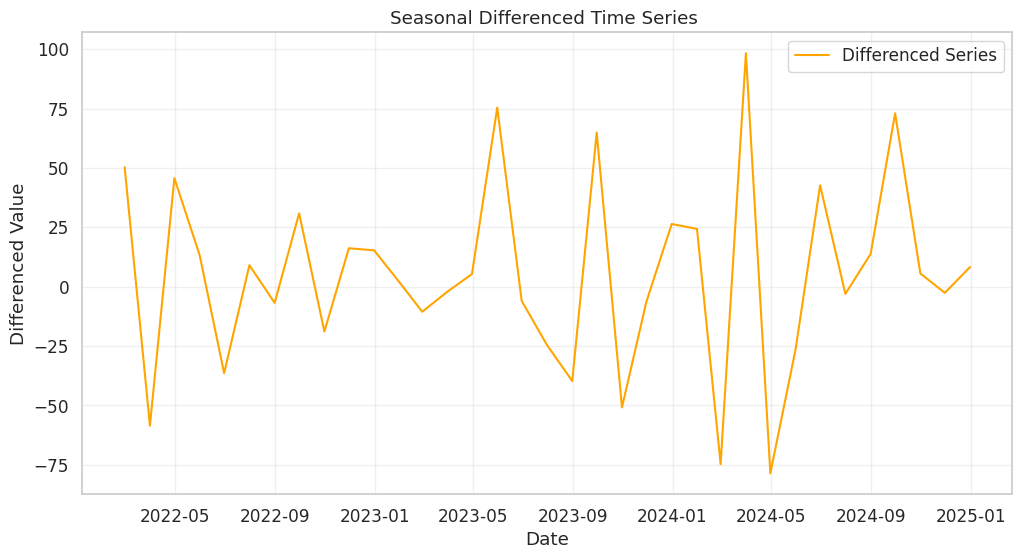

In [158]:
# Apply seasonal differencing (lag 12) 

seasonal_diff = candy_demand['Qty'].diff(12)
diff = seasonal_diff.diff().dropna()

# Plotting the differenced series
plt.figure(figsize=(12, 6))
plt.plot(diff, label='Differenced Series', color='orange')
plt.title('Seasonal Differenced Time Series ')
plt.xlabel('Date')
plt.ylabel('Differenced Value')
plt.grid(True)
plt.legend()
plt.savefig("saved_plots/sales_trend.png")
plt.show()


- The final plot above removed both the trend and seasonal components (yearly cycles). The adjusted data now varies randomly around/closer to zero with less (Almost no) visible patterns, and now the stationarity has been achieved.

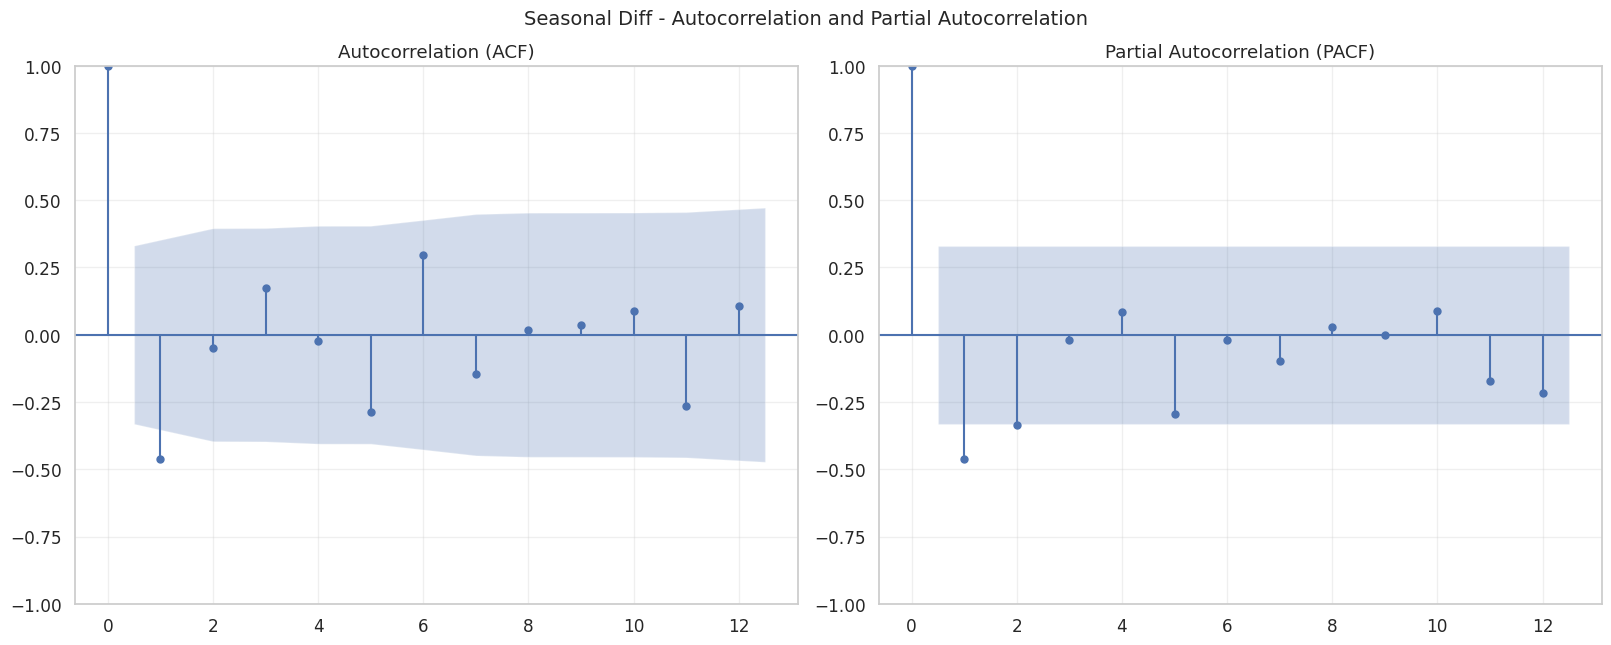

In [164]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), 
                          constrained_layout=True)


fig.suptitle('Seasonal Diff - Autocorrelation and Partial Autocorrelation', 
            fontsize=14, y=1.05)


plot_acf(diff, lags=12, alpha=0.05, ax=ax1, title='Autocorrelation (ACF)')
ax1.grid(True)

plot_pacf(diff, lags=12, alpha=0.05, ax=ax2, title='Partial Autocorrelation (PACF)')
ax2.grid(True)
plt.show()

#### Seasonal ARIMA 

Explanation of Parameters:
order=(1, 0, 1):

p: 1 → 1 non-seasonal AR term.

d: 0 → No regular differencing, since we've already differenced.

q: 1 → 1 non-seasonal MA term.

seasonal_order=(1, 1, 1, 12):

P: 1 → 1 seasonal AR term.

D: 1 → Seasonal differencing (already applied).

Q: 1 → 1 seasonal MA term.

S: 12 → Seasonal period of 12 months.

#### Fitting the Model

In [130]:
# Apply SARIMA model
candy_demand.index.freq = 'M'
model = SARIMAX(diff,
                order=(1, 0, 1),           # Non-seasonal ARIMA order (p, d, q)
                seasonal_order=(1, 1, 1, 12),  # Seasonal order (P, D, Q, S) where S=12 for monthly data
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                Qty   No. Observations:                   35
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                 -47.131
Date:                            Tue, 29 Apr 2025   AIC                            104.262
Time:                                    14:38:20   BIC                            105.248
Sample:                                02-28-2022   HQIC                           102.134
                                     - 12-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1744      0.389     -0.449      0.654      -0.936       0.587
ma.L1         -0.4503      0.616   

- The SARIMAX model results show how well the model fits the data. The model used is SARIMAX(1,0,1)x(1,1,1,12), which means it includes seasonal and non-seasonal components. The log likelihood value is -47.131, which helps measure how well the model explains the data. The AIC (104.262) and BIC (105.248) values are used to compare models, with lower values suggesting a better fit.

- Looking at the coefficients, the autoregressive (AR) term (ar.L1) is -0.1744, but its p-value (0.654) is high, meaning it may not be significant. The moving average (MA) term (ma.L1) is -0.4503, but its p-value (0.465) is also high, suggesting it may not be important. The seasonal AR term (ar.S.L12) is -1.2883 with a p-value of 0.085, which is slightly significant. The seasonal MA term (ma.S.L12) is 0.9972, but its p-value (0.188) is not significant. The high sigma2 value (1037.8649) indicates large errors in the model.

- The Ljung-Box test (Q=0.96, p=0.33) suggests no autocorrelation in residuals, meaning the model captures patterns well. The Jarque-Bera test (JB=0.79, p=0.67) shows residuals are normally distributed. Heteroskedasticity (H=0.23, p=0.26) suggests no major variance issues. However, the warning about the covariance matrix being near-singular means standard errors may be unreliable.

#### Forecast using SARIMA

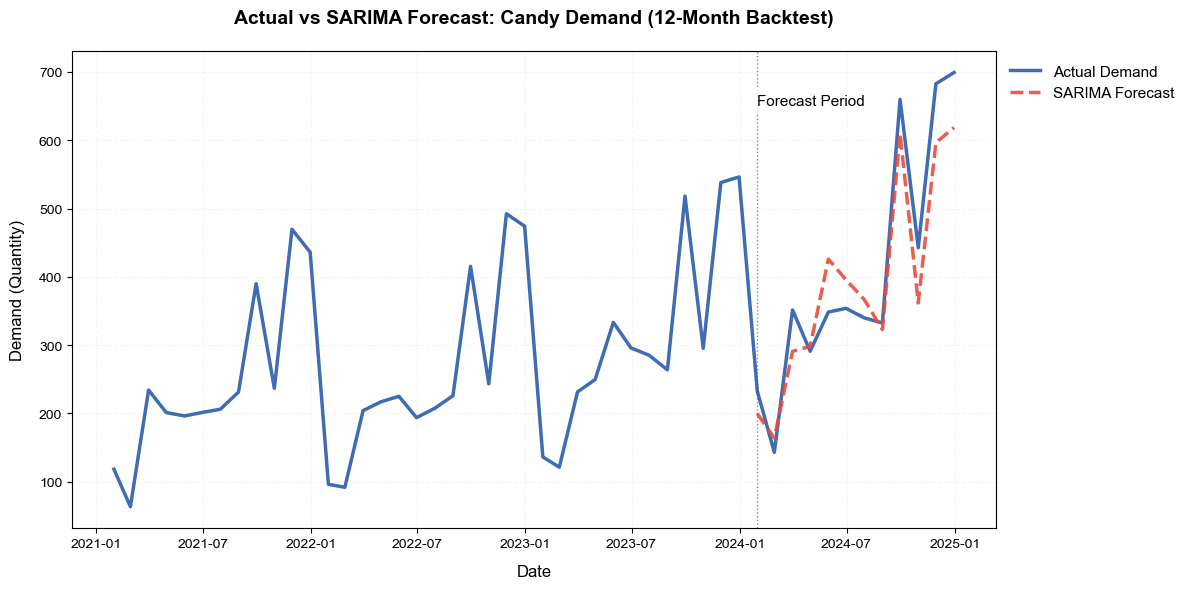

In [133]:
import itertools   
import statsmodels.api as sm  

candy_demand.index.freq = 'M'
model = sm.tsa.statespace.SARIMAX(candy_demand['Qty'],
                                  order=(1, 1, 1),
                                  seasonal_order=(1, 1, 1, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit()

# Generate forecast
candy_demand['Forecast'] = results.predict(
    start=len(candy_demand)-12,
    end=len(candy_demand)-1,
    dynamic=True
)

plt.figure(figsize=(12, 6))
plt.style.use('default') 
plt.rcParams.update({
    'font.family': 'Arial', 
    'grid.color': '#E0E0E0', 
    'grid.linestyle': '--',
    'grid.alpha': 0.3
})


colors = ['#2A5CAA', '#E74C3C'] 

# Plot actual vs forecast
plt.plot(candy_demand['Qty'], 
         label='Actual Demand', 
         color=colors[0], 
         linewidth=2.5,
         alpha=0.9)

plt.plot(candy_demand['Forecast'], 
         label='SARIMA Forecast', 
         linestyle='--', 
         color=colors[1], 
         linewidth=2.5,
         alpha=0.9)

# Highlight forecast period
forecast_start = candy_demand['Forecast'].first_valid_index()
plt.axvline(x=forecast_start, 
            color='#555555', 
            linestyle=':', 
            linewidth=1,
            alpha=0.7)

plt.text(forecast_start, 
         plt.ylim()[1]*0.9, 
         'Forecast Period', 
         ha='left', 
         va='center',
         fontsize=11,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Titles and labels
plt.title('Actual vs SARIMA Forecast: Candy Demand (12-Month Backtest)', 
          fontsize=14, 
          pad=20, 
          fontweight='semibold')
plt.xlabel('Date', fontsize=12, labelpad=10)
plt.ylabel('Demand (Quantity)', fontsize=12, labelpad=10)
plt.legend(frameon=True, 
           facecolor='white', 
           edgecolor='none',
           fontsize=11,
           bbox_to_anchor=(1, 1)) 
plt.grid(True)
plt.tight_layout()
plt.savefig("saved_plots/sales_trend.png", 
            dpi=300, 
            bbox_inches='tight', 
            transparent=False)


plt.show()

### Hyperparameter Tuning - Grid Search 
generate the best Sarima parameters using grid search

In [134]:
warnings.filterwarnings("ignore")

# Narrowed parameter ranges
p = q = range(0, 4)       # try AR/MA orders 0–4
d = [0,1]               # differencing order 0 or 1
P = Q = range(0, 4)      # seasonal AR/MA orders 0–3
D =  range(0, 3)             # seasonal differencing 0 or 1 or 2
s = 12                   # monthly seasonality

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [s]))

best_aic = np.inf
best_params = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(
                candy_demand['Qty'],
                order=param,
                seasonal_order=seasonal_param,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, seasonal_param)
        except:
            continue



In [135]:
# Print the best parameters

print("Best SARIMA Parameters Found:")
print(f"Order (p,d,q):       {best_params[0]}")
print(f"Seasonal Order (P,D,Q,12): {best_params[1]}")
print(f"AIC: {best_aic:.2f}")


Best SARIMA Parameters Found:
Order (p,d,q):       (0, 0, 0)
Seasonal Order (P,D,Q,12): (0, 2, 2, 12)
AIC: 6.00


#### Fitting SARIMA using best parameters from Grid Search

In [136]:
# Fit with best parameters
model = sm.tsa.statespace.SARIMAX(candy_demand['Qty'],
                                  order=best_params[0],
                                  seasonal_order=best_params[1],
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit()



#### Forecast last 12 months (backtest), to see how well the model will perform :

<Axes: title={'center': 'Forecast vs Actual Using the Best Parameters from Grid Search'}, xlabel='Order_Date'>

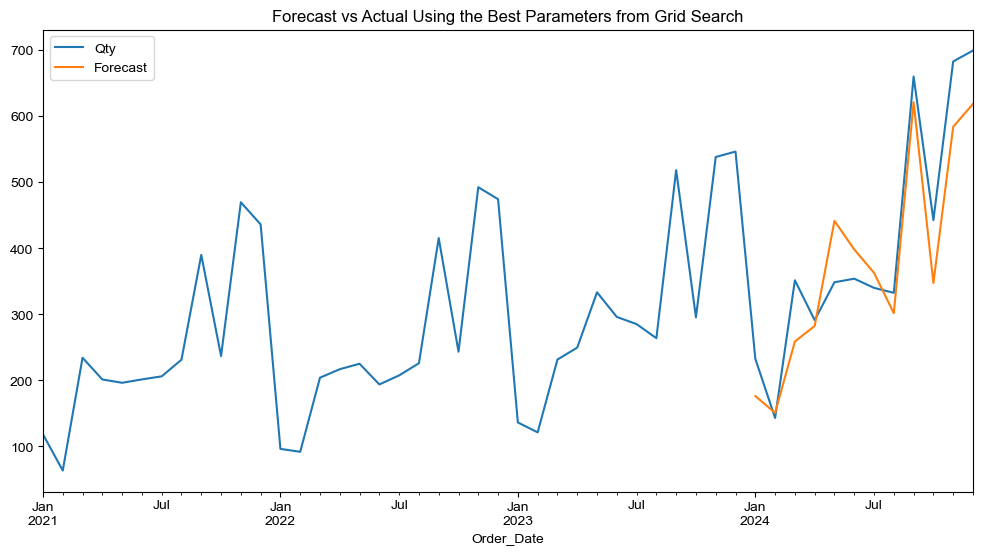

In [137]:
# Forecast last 12 months (backtest)
candy_demand['Forecast'] = results.predict(start=len(candy_demand)-12,
                                           end=len(candy_demand)-1,
                                           dynamic=True)


candy_demand[['Qty', 'Forecast']].plot(figsize=(12, 6), title="Forecast vs Actual Using the Best Parameters from Grid Search")

In [138]:
y_true = candy_demand['Qty'].iloc[-12:]  # Last 12 months of actual data
y_pred = candy_demand['Forecast'].iloc[-12:]  # Last 12 months of forecast data

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)



In [139]:
# Print the results

print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"MSE (Mean Squared Error): {mse:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"R2 (R-squared): {r2:.2f}")


MAE (Mean Absolute Error): 55.84
MSE (Mean Squared Error): 4238.55
RMSE (Root Mean Squared Error): 65.10
R2 (R-squared): 0.86


- The R2  value is 86%, which is quite good. This means the model explains 86% of the variation in the demand data, showing it fits the past data well. A high R2 suggests the SARIMA model is effective for this forecasting task. Overall, these results indicate that the model performs well, with reasonably small errors and a strong ability to capture patterns in the data. However, there is still some error.
The image displays a SARIMAX model's historical fit and 12-month forecast for electricity generation. The fitted values follow the actual data closely, showing a strong in-sample fit, while the forecast predicts a steady or slightly rising trend. However, the model might not fully account for sudden demand changes or external shocks, like policy shifts or extreme weather, as forecasts tend to smooth out volatility. 
The truth is, none of the SARIMA models worked really well. The best performance gotten was an R2 of 73% and a MAPE of at least 15.61%. They failed to capture the trend and struggled with yearly seasonality. Ideally, I’d refine the parameters, but grid search takes too long to run. I’m not sure whether to try a different tuning strategy or if the model just isn’t right for this task.

#### Using the final Model To Make Future Prediction:

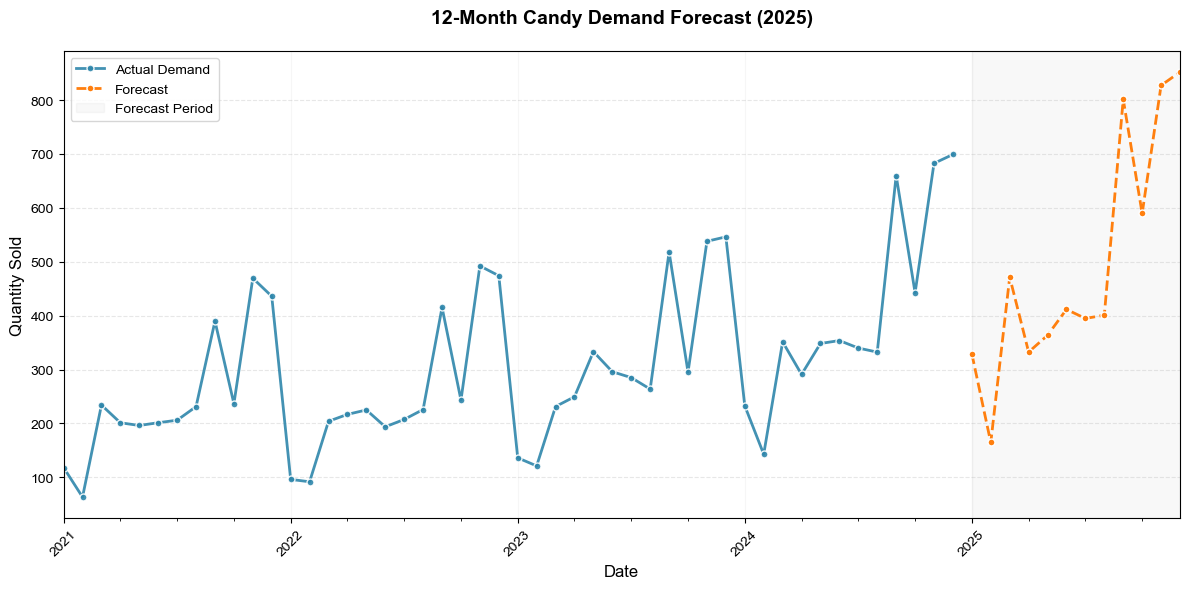

In [141]:
# --- Forecast the next 12 months ---
forecast_future = results.predict(
    start=len(candy_demand), 
    end=len(candy_demand) + 11,  # Next 12 months
    dynamic=False
)

# Forecast DataFrame
forecast_future_index = pd.date_range(
    start=candy_demand.index[-1] + pd.Timedelta(days=1), 
    periods=12, 
    freq='M'
)
forecast_future_series = pd.Series(forecast_future, index=forecast_future_index)

# --- Plot Styling ---
plt.figure(figsize=(12, 6))
plt.style.use('default')  
plt.rcParams.update({
    'font.family': 'Arial',  
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'axes.grid': True,
    'grid.alpha': 0.3
})

# Plot historical data
ax = candy_demand['Qty'].plot(
    color='#2E86AB', 
    linewidth=2,
    label='Actual Demand',
    alpha=0.9,
    marker='o',
    markersize=5,
    markeredgecolor='white'
)

# Plot forecast
forecast_future_series.plot(
    color='#FF7F0E', 
    linestyle='--',
    linewidth=2,
    label='Forecast',
    marker='o',
    markersize=5,
    markeredgecolor='white'
)

plt.title(
    "12-Month Candy Demand Forecast (2025)", 
    pad=20, 
    fontweight='bold'
)
ax.set_xlabel("Date")
ax.set_ylabel("Quantity Sold")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax.axvspan(
    forecast_future_index[0], 
    forecast_future_index[-1], 
    color='gray', 
    alpha=0.05, 
    label='Forecast Period'
)

ax.legend(
    loc='upper left', 
    frameon=True, 
    facecolor='white',
    framealpha=0.8
)


plt.xticks(rotation=45)

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.grid(axis='x', alpha=0.1)

plt.tight_layout()
plt.show()

- The SARIMA model forecasts demand for the next 12 months (2025), showing fluctuations each month. Starting with a sharp drop in February after a moderate January, demand rises significantly in March. A major surge occurs in September, followed by another peak in November and December, suggesting strong seasonal trends towards year-end.
  
- This information is highly valuable for the Candy Distributor as it helps optimize stock levels, manage cash flow and prepare for seasonal peaks. The predicted surges in September, November, and December align with key candy-buying seasons like Halloween, Christmas, and holiday gifting, ensuring the distributor can ramp up inventory and promotions ahead of time. Meanwhile, the sharp drop in February suggests lower demand post-holidays, allowing the business to reduce orders and avoid overstocking. The mid-year stability (June–August) indicates steady demand, helping with consistent supply planning. By anticipating these trends, the distributor can minimize waste, improve delivery efficiency, and maximize sales during high-demand periods while avoiding unnecessary costs in slower months.